In [1]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian, KFAC, DiagGGNExact
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F
#from torch.utils.data import Dataset
#from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
#from scipy.stats import pearsonr
#from mpl_toolkits.axes_grid1 import AxesGrid
#import mpl_toolkits as mpl
#from scipy.stats import chi2, norm
#import random
#import warnings
#warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, linregress
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import random

#plt.rcParams["mpl_toolkits.legacy_colorbar"] = False

s=2
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#plt stuff
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
#scatterlist = []

In [3]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

def flattenlist(lst):
    flat_list = []
    for sublist in lst:
        for item in sublist:
            flat_list.append(item)
    return flat_list

## Create Dataset

In [25]:
class NumbersDataset(Dataset):
    
    def __init__(self):
        self.mean = 0
        self.std = 0.2 #0.6
        self.size = 5000
        self.mult = 2
        self.exp = 2
        self.noise = np.random.normal(loc=self.mean, scale=self.std, size=self.size)
        self.nums = np.linspace(-20, 30, self.size)
        #self.nums = self.nums + self.noise
        self.samples = []#torch.cat([self.nums + self.noise, 2*self.nums]).view(-1,2)
        for i, elem in enumerate(self.nums):
            self.samples.append((elem + self.noise[i] , elem **self.exp))
        #self.samples = torch.tensor(self.samples)
    def __noise__(self):
        return self.noise
    
    def __shape__(self):
        return self.samples.size()
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        num, label = self.samples[idx]
        return num, label
        #$return self.samples[idx]
    
    def __plot__(self):
        inpt = []
        targ = []
        for tuplee in self.samples:
            inpt.append(tuplee[0])
            targ.append(tuplee[1])
        plt.scatter(inpt, targ)
        #plt.show()

if __name__ == '__main__':
    dataset = NumbersDataset()
    trainset, testset = random_split(dataset, [4000, 1000])
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True)#, num_workers=2)
    testloader = DataLoader(testset, batch_size=5, shuffle=False, num_workers=2)
    #print(len(dataset
    #print(dataset[99])
    #print(dataset[0])
    for i, batch in enumerate(trainloader):
        if i > 0:
            break
        print(i, batch)
        

0 [tensor([  2.8498,  20.6844,  19.1470,   3.9539,  13.5777,  24.6587, -14.1711,
         -0.6888,  -3.3158,  28.6929,  17.5518,  21.8897,   4.4550,  -1.7604,
         12.9855, -19.7157, -11.9882, -18.2286,   8.7048, -20.0911,  17.0393,
        -14.4869,  23.7716,   3.3661,  20.2220,  28.7185,  -8.0844,   4.7261,
         18.6843,  -2.6878,  17.7975,  -3.7910, -17.3861,  -0.6441,  18.7977,
          5.3331,  -1.8959,  12.5348,  -5.7397,   5.2744,  24.8818,  -3.5175,
         29.0244, -18.5000,  15.6905,  -3.5647,  14.9884,  -9.0245, -15.7269,
         25.2726, -16.6757,  -0.1826,   7.4010,  -6.8643,  20.4250, -19.3969,
          0.2478,  11.3578,  11.2900,  -7.9805,  19.6617,   2.3984, -19.0503,
        -11.7290,   0.0724,   5.8490, -11.3946, -16.5969,  18.2186,   7.1110,
         14.7116, -14.6620,  -8.9536, -14.7869,  28.8379, -12.7875,  18.7509,
         12.3550,   4.7986,  -3.6145, -14.2453,  -5.5236, -13.7596, -10.2966,
         10.0636,  17.3852, -11.8532,   7.7906, -16.7302, -15

## Define Perceptron

In [21]:
## Define Perceptron

def NN(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(1, sz), 
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz), #good
        torch.nn.ReLU(),
        #extension starts here
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),#good
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        #torch.nn.Linear(sz, sz),
        #torch.nn.ReLU(),
        torch.nn.Linear(sz, 1)
        
    )
    return(features)

def NN_deep(sz):
    
    features = torch.nn.Sequential(
        torch.nn.Linear(1, sz), 
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz), #good
        torch.nn.ReLU(),
        #extension starts here
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),#good
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, sz),
        torch.nn.ReLU(),
        torch.nn.Linear(sz, 1)
        
    )
    return(features)

net = NN(sz= 2)

lossfunction = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0000001)
#optimizer = torch.optim.SGD(net.parameters() , lr = 0.01)#, momentum= 0.9)

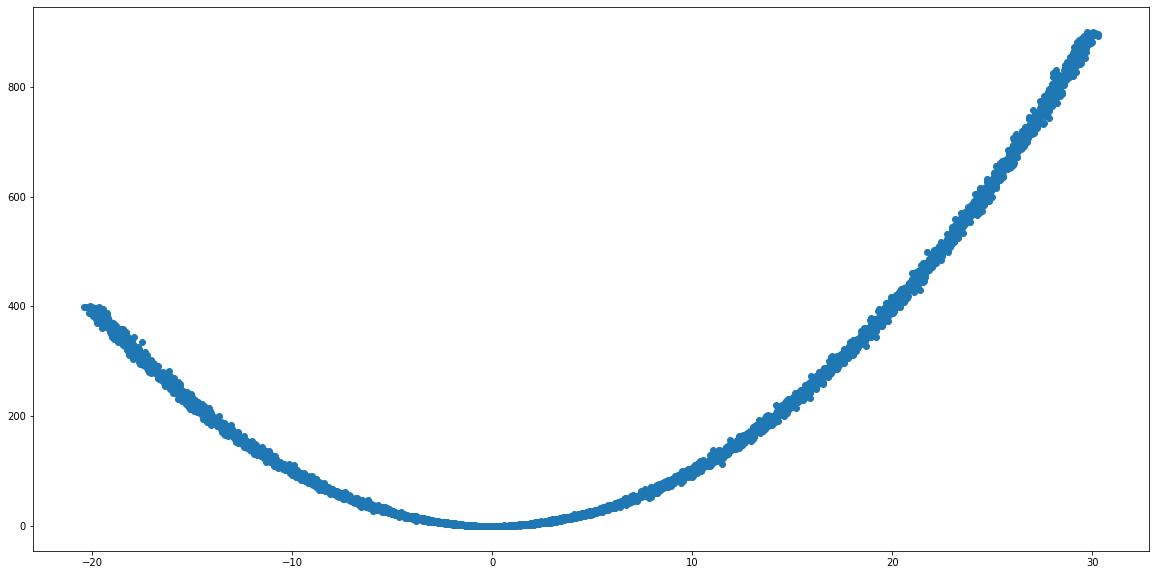

In [6]:
plt.rcParams["figure.figsize"] = (20,10)
dataset.__plot__()

## Define training procedure

In [26]:
def trainloop():
    
    for epoch in range(500):
        for i, (inputs, targets) in enumerate(trainloader):
            X, Y = inputs.float(), targets.float()
            X, Y =  X.view(X.size(0), -1), Y.view(Y.size(0), -1)
            #print(X, Y)
            #print(X, Y)
            #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)
            optimizer.zero_grad()
            outputs = net(X)
            loss = lossfunction(outputs, Y)
            loss.backward()
            optimizer.step()
            if (i % 1000 == 0):
                print("Epoch {} - loss: {}".format(epoch, loss.data.item()))
    

In [27]:
trainloop()

Epoch 0 - loss: 80762.625
Epoch 1 - loss: 112154.390625
Epoch 2 - loss: 96926.3984375
Epoch 3 - loss: 108419.28125
Epoch 4 - loss: 100113.421875
Epoch 5 - loss: 71443.1796875
Epoch 6 - loss: 109172.4453125
Epoch 7 - loss: 107609.90625
Epoch 8 - loss: 129876.5703125
Epoch 9 - loss: 99004.296875
Epoch 10 - loss: 134847.5
Epoch 11 - loss: 87295.5703125
Epoch 12 - loss: 92463.9375
Epoch 13 - loss: 90955.453125
Epoch 14 - loss: 105173.8671875
Epoch 15 - loss: 104848.921875
Epoch 16 - loss: 81587.3828125
Epoch 17 - loss: 71967.40625
Epoch 18 - loss: 116095.2109375
Epoch 19 - loss: 105899.3203125
Epoch 20 - loss: 119940.0
Epoch 21 - loss: 110339.375
Epoch 22 - loss: 104997.0859375
Epoch 23 - loss: 124397.3125
Epoch 24 - loss: 137633.75
Epoch 25 - loss: 118900.390625
Epoch 26 - loss: 127442.328125
Epoch 27 - loss: 130216.1953125
Epoch 28 - loss: 102123.46875
Epoch 29 - loss: 121670.140625
Epoch 30 - loss: 101585.375
Epoch 31 - loss: 114331.09375
Epoch 32 - loss: 99042.4375
Epoch 33 - loss: 842

Epoch 265 - loss: 93980.5234375
Epoch 266 - loss: 102231.1875
Epoch 267 - loss: 124595.84375
Epoch 268 - loss: 113148.296875
Epoch 269 - loss: 91930.015625
Epoch 270 - loss: 112154.6328125
Epoch 271 - loss: 98952.265625
Epoch 272 - loss: 100707.7109375
Epoch 273 - loss: 126601.453125
Epoch 274 - loss: 129216.53125
Epoch 275 - loss: 118557.0078125
Epoch 276 - loss: 114661.1171875
Epoch 277 - loss: 134802.140625
Epoch 278 - loss: 96901.34375
Epoch 279 - loss: 83875.9375
Epoch 280 - loss: 95542.328125
Epoch 281 - loss: 137899.65625
Epoch 282 - loss: 148703.515625
Epoch 283 - loss: 75798.8046875
Epoch 284 - loss: 128555.171875
Epoch 285 - loss: 113638.25
Epoch 286 - loss: 105130.390625
Epoch 287 - loss: 107219.5625
Epoch 288 - loss: 113497.8515625
Epoch 289 - loss: 87659.109375
Epoch 290 - loss: 111644.375
Epoch 291 - loss: 108111.96875
Epoch 292 - loss: 126574.421875
Epoch 293 - loss: 128989.1640625
Epoch 294 - loss: 124488.421875
Epoch 295 - loss: 111427.8359375
Epoch 296 - loss: 105334.

In [28]:
def fitting(state, size):    
    mpl.rcParams['agg.path.chunksize'] = 10000
    model = NN(size)
    model.load_state_dict(state)
    
    inp = []
    outp = []
    targs = []
    max_len = len(testloader)
    for batch_idx, (inputs, targets) in enumerate(testloader):
            X, Y = inputs.float(), targets.float() #iter(data2)
            X, Y =  X.view(X.size(0), -1), Y.view(Y.size(0), -1)
            inp.append(X)
            targs.append(Y)
            output = model(X)
            outp.append(output)
    inp, outp, targs = torch.tensor(flattenlist(inp)), torch.tensor(flattenlist(outp)), torch.tensor(flattenlist(targs))    


    plt.plot(list(inp),list(outp), 'yo')#, inp, targs, '--k')
    #plt.plot(inp,targs, 'yo')
    dataset.__plot__()
    #plt.xlim(-20, 30)
    #plt.ylim(-40, 60)
    plt.show()

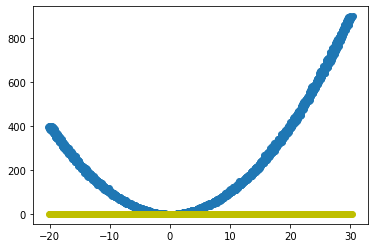

In [29]:
#plt.plot(inp, outp)
#plt.plot(inp.tolist(), outp.tolist())
fitting(net.state_dict(), 2)

In [597]:
#slope : slope of the regression line
#intercept : intercept of the regression line
#r-value : correlation coefficient
#p-value : two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero
#stderr : Standard error of the estimate

print('trained:')
print(linregress(inp,outp))
print()
print('dataset:')
print(linregress(inp,targs))

trained:
LinregressResult(slope=11.638749849072617, intercept=168.9502892658287, rvalue=0.6411609206674822, pvalue=6.679266569700177e-13, stderr=1.4071866382886555)

dataset:
LinregressResult(slope=11.572192815241694, intercept=170.19157866197065, rvalue=0.6368511684542557, pvalue=1.060786148564057e-12, stderr=1.4151797167399967)


### see if network trained correct weight

In [33]:
#print(list(net.named_parameters()))
#print()
print(net(Variable(torch.Tensor([[[10]]]))))

tensor([[[101.9538]]], grad_fn=<AddBackward0>)


## calculate Hessians: DiagHessian

In [8]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = lossfunction

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):
            
            
            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()
            else:
                x, y = torch.tensor(x).float(), torch.tensor(y).float()
            #print(x, y)

            model.zero_grad()
            x, y = x.view(-1, 1), y.view(-1, 1) 
                        
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #print(H_)
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [836]:
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)

parameter size:  torch.Size([5, 1])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([5, 5])
parameter size:  torch.Size([5])
parameter size:  torch.Size([1, 5])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [869]:
#print(perceptronDiagH)#[0].item())
#print(perceptronDiagGGN)

## Analyze x**3 (depth: 6 hl)

### size 4

In [35]:
#x2state_4 = net.state_dict()

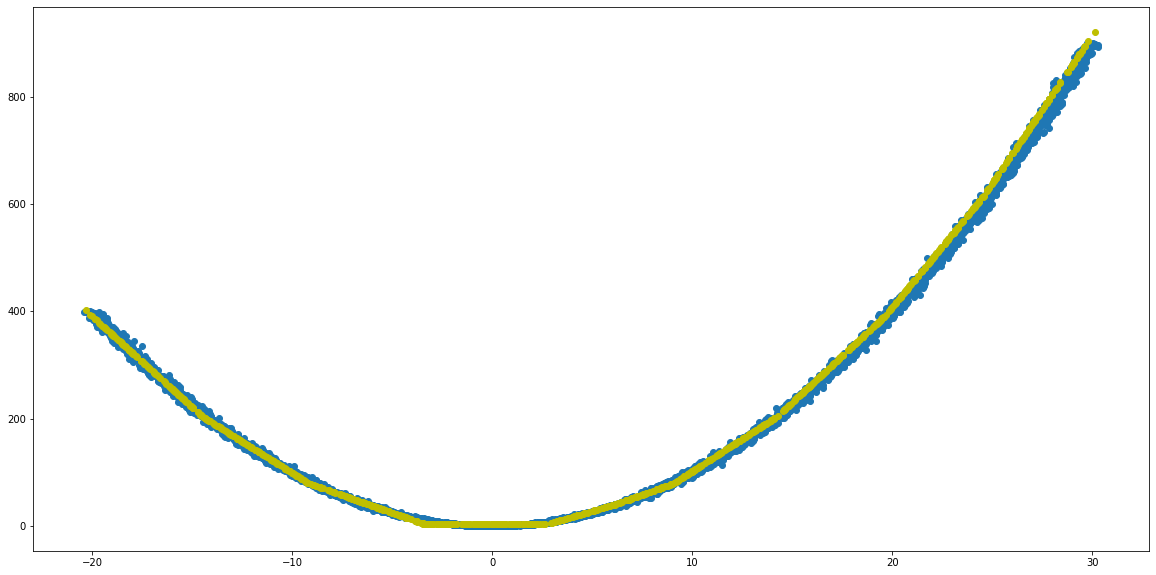

In [36]:
fitting(x2state_4, 4)

In [120]:
net = NN(sz=4)
net.load_state_dict(x2state_4)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
width4 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width4.append(torch.mean(param).item())

parameter size:  torch.Size([4, 1])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([1, 4])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.0029)
tensor(1.7808)
tensor(1.9871)
tensor(1.3949)
tensor(2.0153)
tensor(1.5843)


### size 10 

In [41]:
#x2state_10 = net.state_dict()

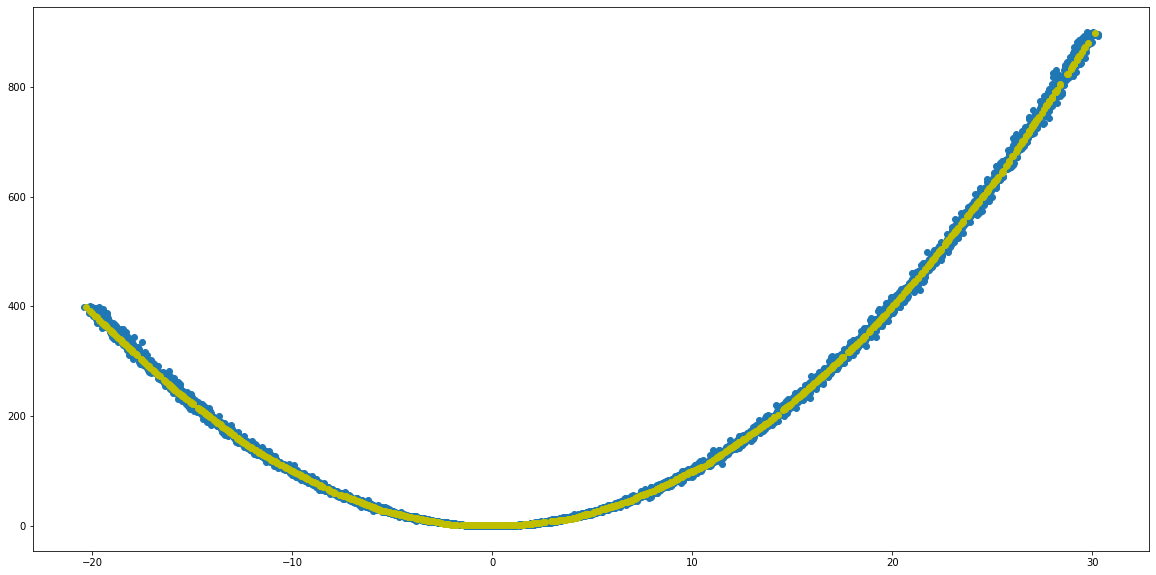

In [42]:
fitting(x2state_10, 10)

In [119]:
net = NN(sz=10)
net.load_state_dict(x2state_10)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
width10 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width10.append(torch.mean(param).item())

parameter size:  torch.Size([10, 1])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([1, 10])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.9639)
tensor(2.0090)
tensor(1.8255)
tensor(2.1955)
tensor(2.1275)
tensor(0.9611)


### size 20

In [47]:
#x2state_20 = net.state_dict()

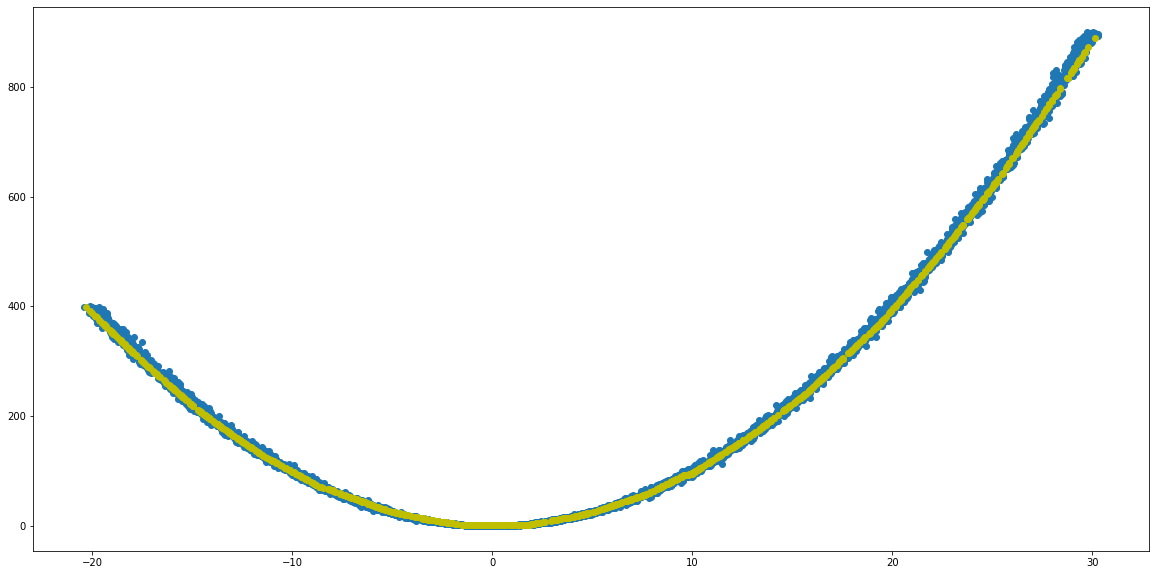

In [48]:
fitting(x2state_20, 20)

In [118]:
net = NN(sz=20)
net.load_state_dict(x2state_20)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
width20 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width20.append(torch.mean(param).item())

parameter size:  torch.Size([20, 1])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([1, 20])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(1.2687)
tensor(2.6551)
tensor(3.0237)
tensor(2.9634)
tensor(2.7086)
tensor(2.0784)


In [53]:
#x2state_160 = net.state_dict()

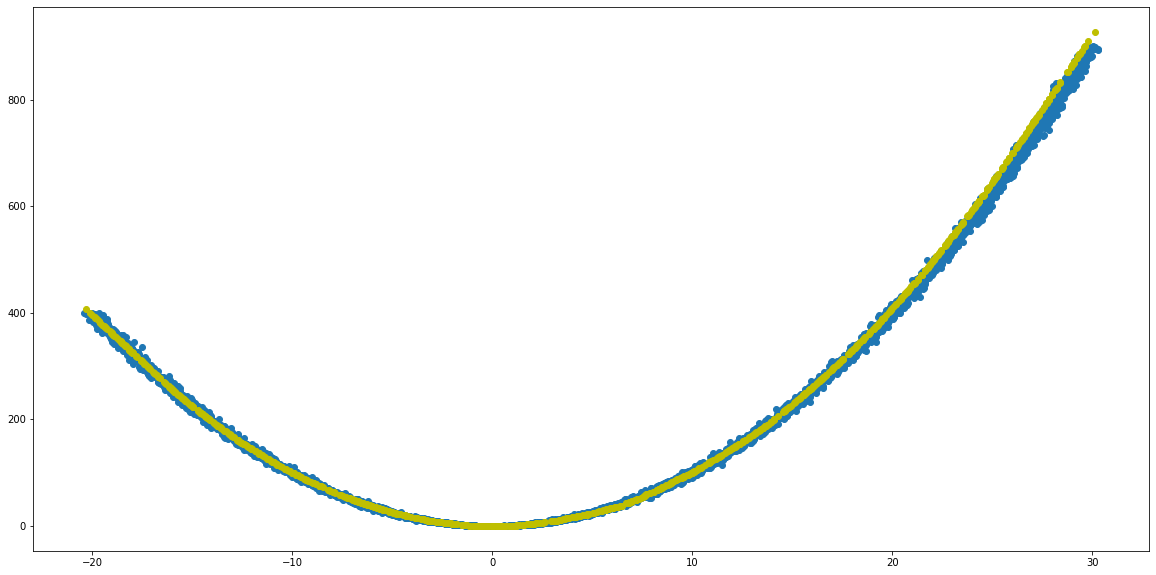

In [54]:
fitting(x2state_160, 160)

In [116]:
net = NN(sz=160)
net.load_state_dict(x2state_160)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
width160 = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width160.append(torch.mean(param).item())

parameter size:  torch.Size([160, 1])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([1, 160])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(1.7754)
tensor(3.1290)
tensor(3.1581)
tensor(3.1519)
tensor(3.1507)
tensor(3.0464)


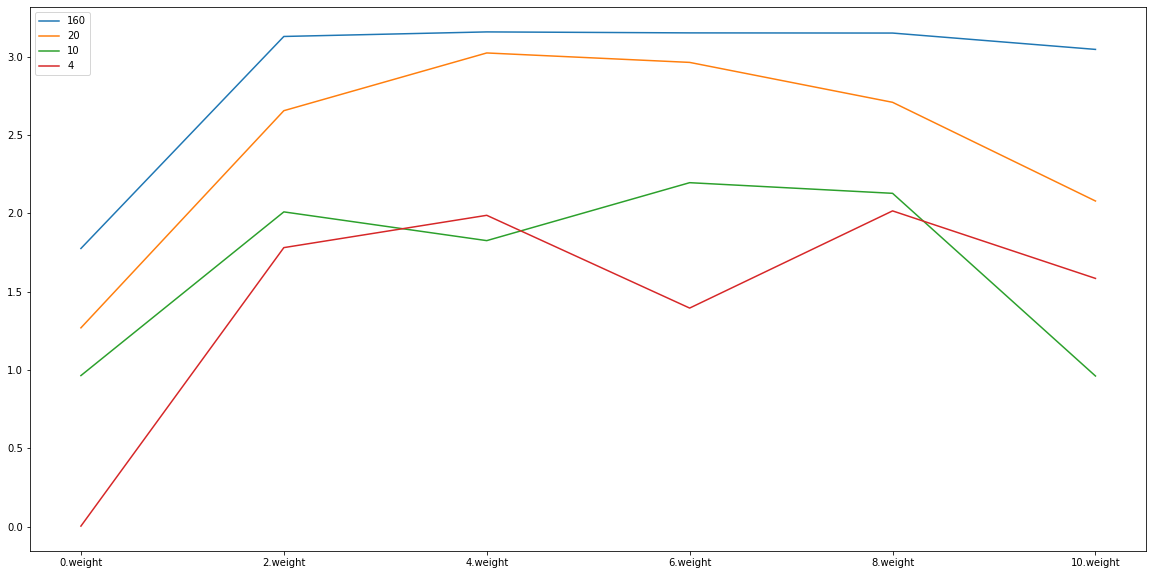

In [121]:
line, = plt.plot(layrnames, width160)
line.set_label('160')
line, = plt.plot(layrnames, width20)
line.set_label('20')
line, = plt.plot(layrnames, width10)
line.set_label('10')
line, = plt.plot(layrnames, width4)
line.set_label('4')
plt.legend()

## x**3 (depth: 10)

### size 5

In [63]:
#x2state_4_deep = net.state_dict()

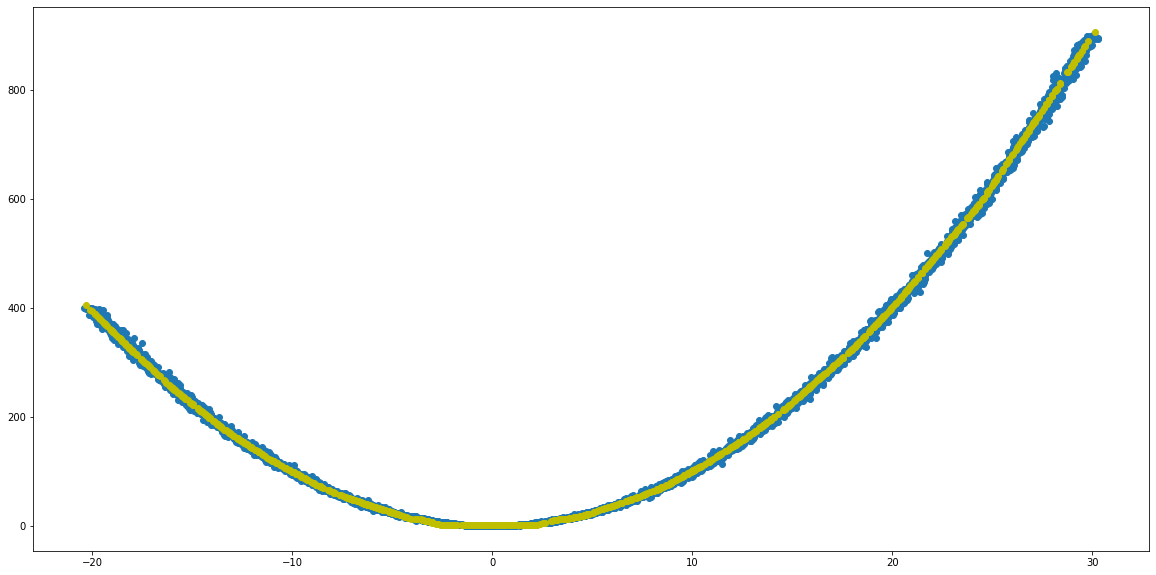

In [64]:
fitting(x2state_4_deep, 4)

In [107]:
net = NN_deep(sz=4)
net.load_state_dict(x2state_4_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
width4deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width4deep.append(torch.mean(param).item())

parameter size:  torch.Size([4, 1])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([1, 4])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.0026)
tensor(1.6052)
tensor(0.7995)
tensor(0.8057)
tensor(1.2019)
tensor(1.9351)
tensor(1.9799)
tensor(1.9823)
tensor(1.5902)
tensor(0.0070)


### size 10

In [69]:
#x2state_10_deep = net.state_dict()

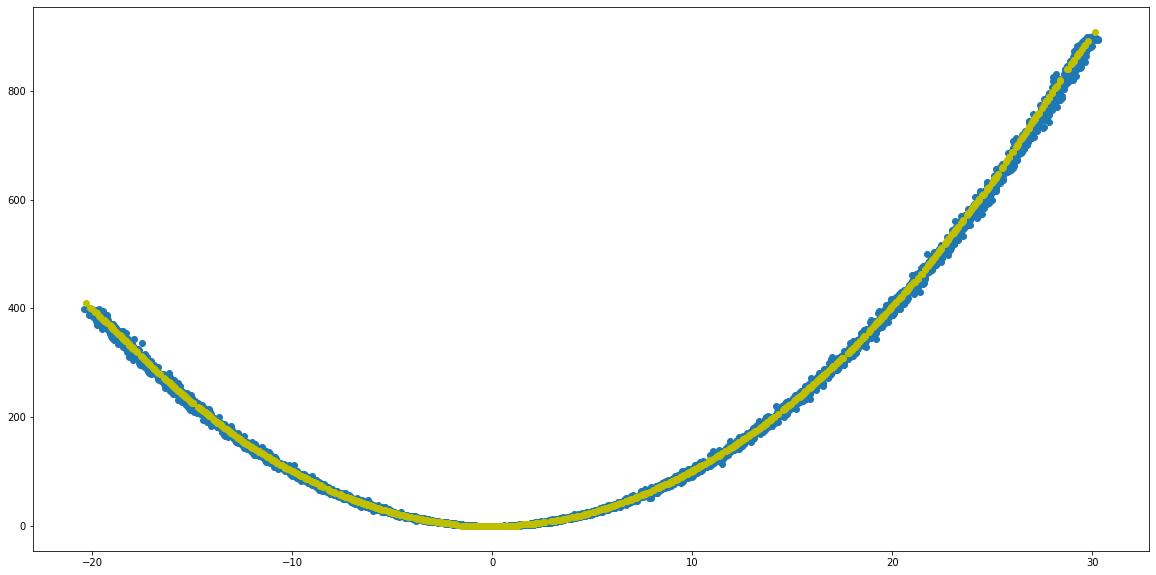

In [70]:
fitting(x2state_10_deep, 10)

In [108]:
net = NN_deep(sz=10)
net.load_state_dict(x2state_10_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
width10deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width10deep.append(torch.mean(param).item())

parameter size:  torch.Size([10, 1])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([10, 10])
parameter size:  torch.Size([10])
parameter size:  torch.Size([1, 10])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.3216)
tensor(0.8742)
tensor(1.6303)
tensor(1.6875)
tensor(1.4174)
tensor(1.4719)
tensor(1.4736)
tensor(1.6112)
tensor(2.0931)
tensor(1.2685)


### size 20

In [75]:
#x2state_20_deep = net.state_dict()

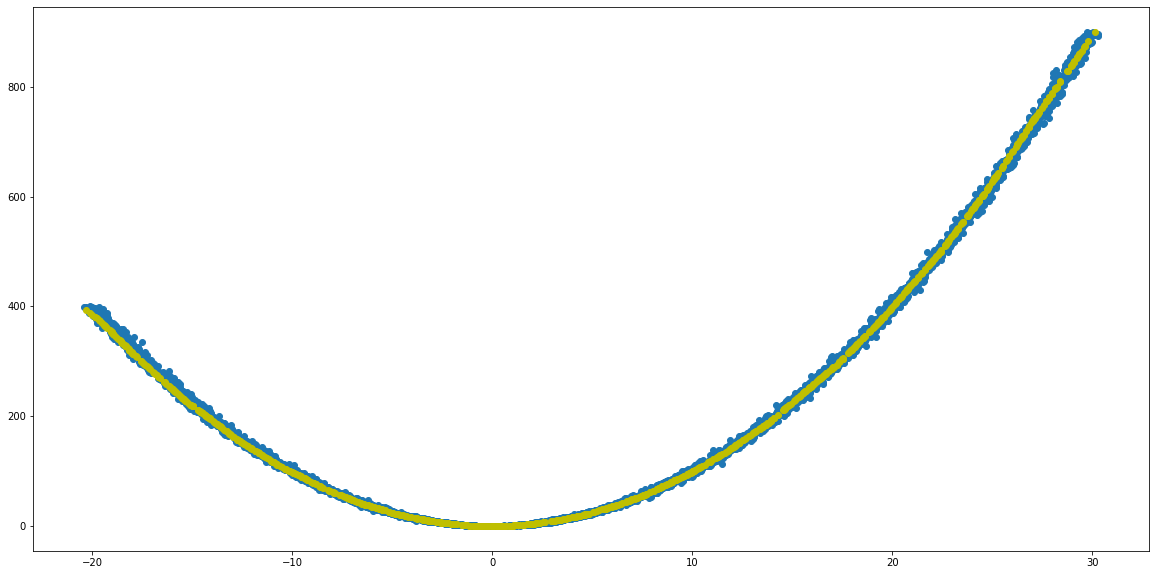

In [76]:
fitting(x2state_20_deep, 20)

In [109]:
net = NN_deep(sz=20)
net.load_state_dict(x2state_20_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
width20deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width20deep.append(torch.mean(param).item())

parameter size:  torch.Size([20, 1])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([20, 20])
parameter size:  torch.Size([20])
parameter size:  torch.Size([1, 20])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.1766)
tensor(1.8087)
tensor(1.7078)
tensor(1.5340)
tensor(1.5016)
tensor(1.1644)
tensor(1.3889)
tensor(1.8825)
tensor(2.5301)
tensor(2.0703)


### size 160

In [81]:
#x2state_160_deep = net.state_dict()

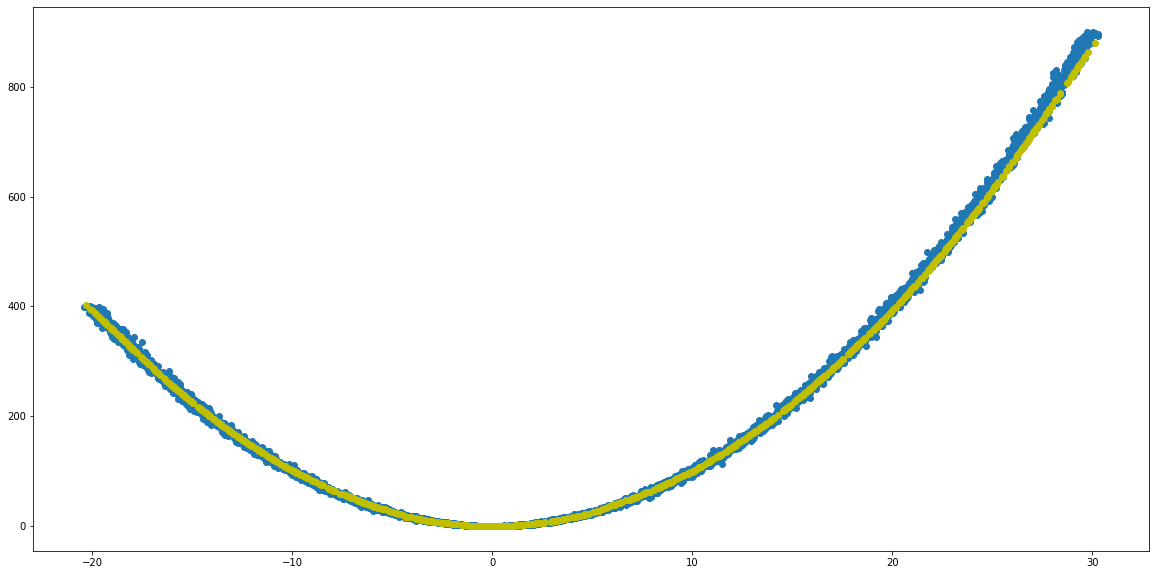

In [82]:
fitting(x2state_160_deep, 160)

In [110]:
net = NN_deep(sz=160)
net.load_state_dict(x2state_160_deep)
perceptronDiagH = get_Hessian_NN(model=net, train_loader=trainloader, prec0=0.1, verbose=False)
width160deep = []
for i, param in enumerate(perceptronDiagH):
    if i %2 == 0:
        print(torch.mean(param))
        width160deep.append(torch.mean(param).item())

parameter size:  torch.Size([160, 1])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([160, 160])
parameter size:  torch.Size([160])
parameter size:  torch.Size([1, 160])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.1783)
tensor(2.9421)
tensor(3.1035)
tensor(3.0542)
tensor(3.0224)
tensor(2.9273)
tensor(2.8073)
tensor(2.8874)
tensor(2.9217)
tensor(2.1409)


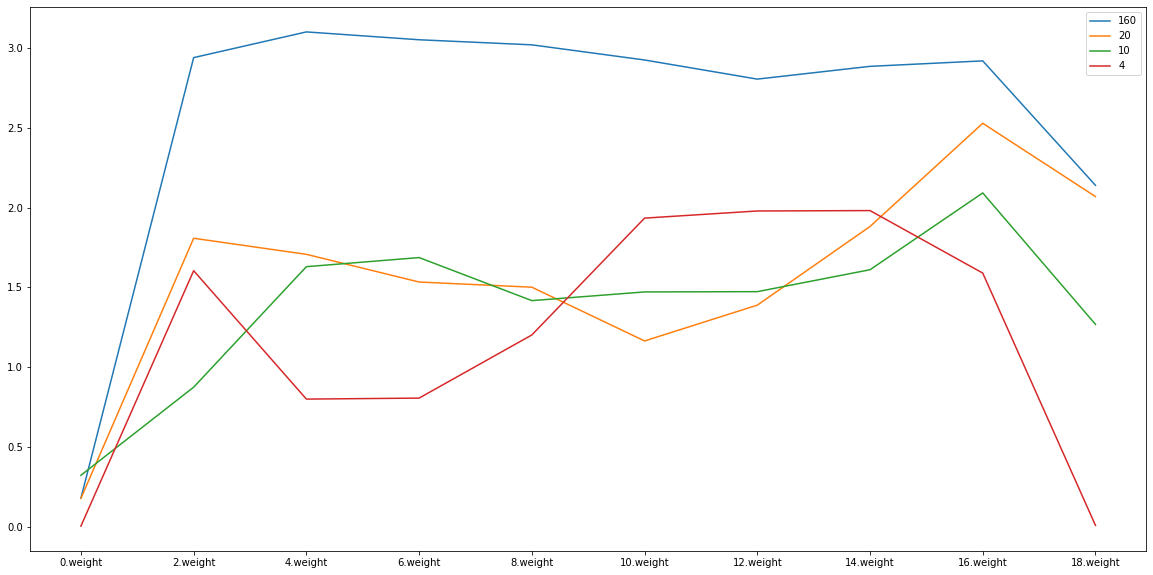

In [122]:
line, = plt.plot(deepnames, width160deep)
line.set_label('160')
line, = plt.plot(deepnames, width20deep)
line.set_label('20')
line, = plt.plot(deepnames, width10deep)
line.set_label('10')
line, = plt.plot(deepnames, width4deep)
line.set_label('4')
plt.legend()

In [113]:
deepnames = []
for key in x2state_160_deep.keys():
    if 'weight' in key:
        deepnames.append(key)
layrnames = []
for key in x2state_160.keys():
    if 'weight' in key:
        layrnames.append(key)

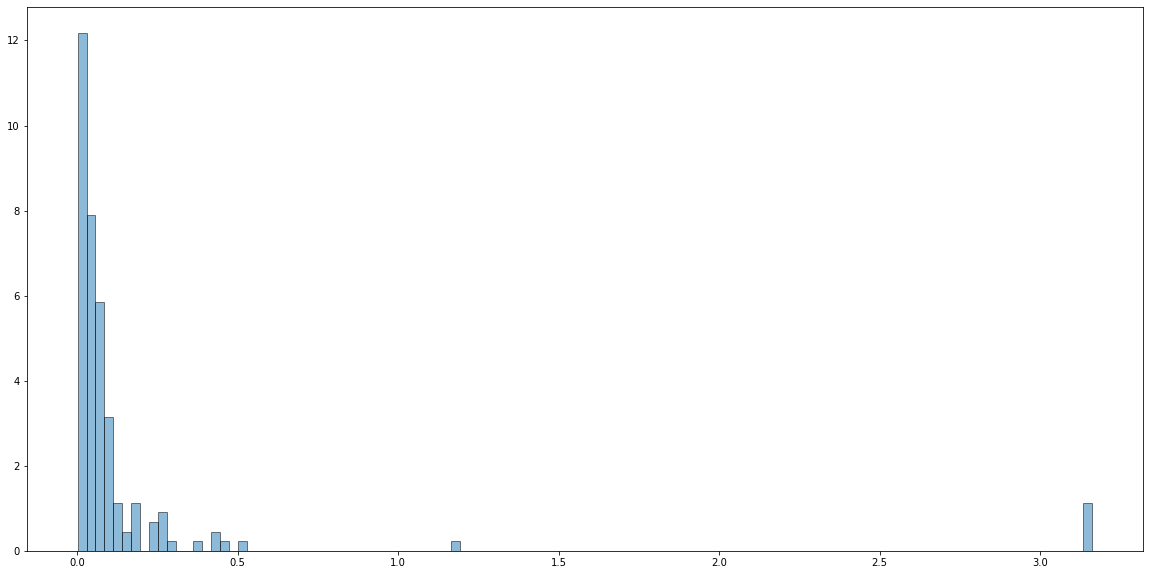

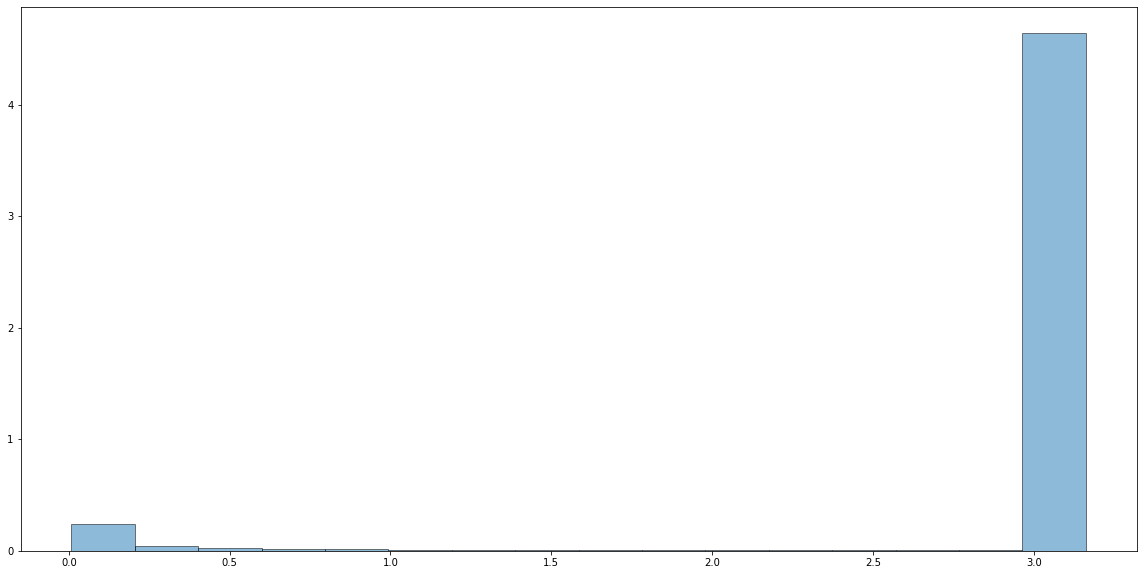

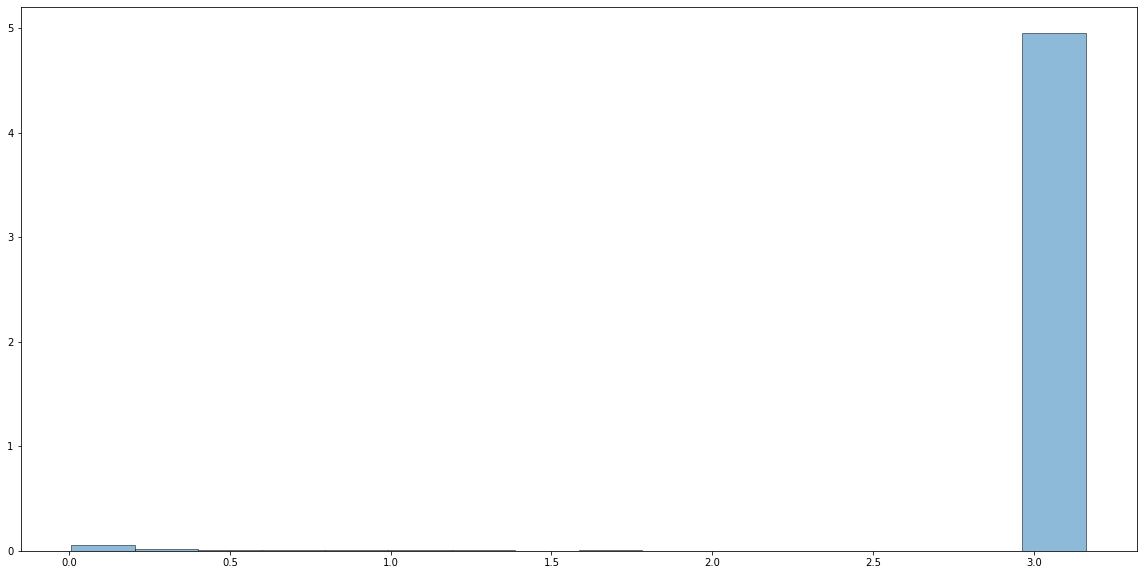

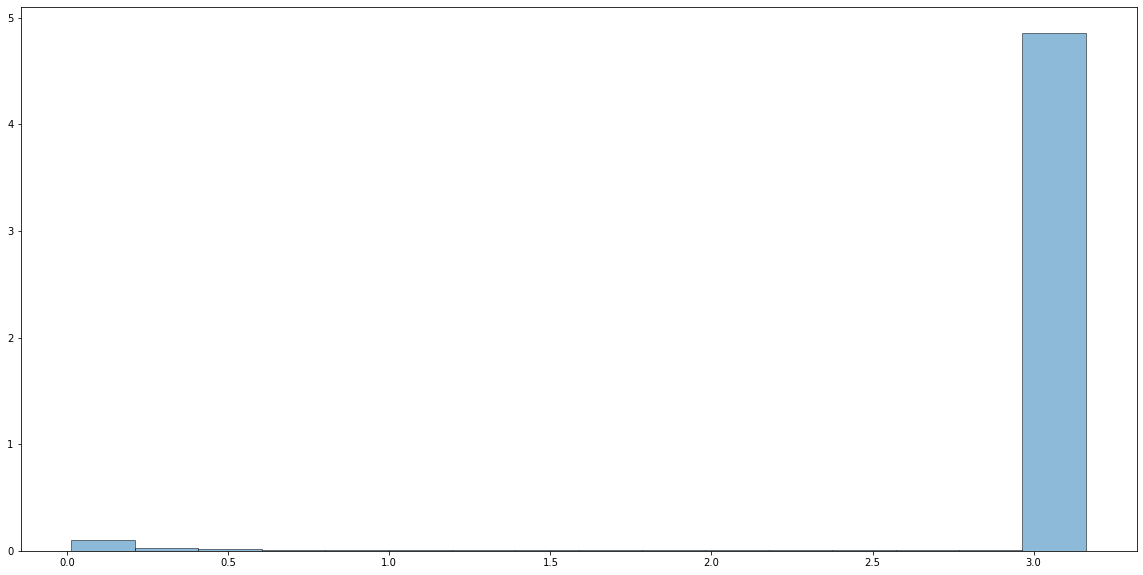

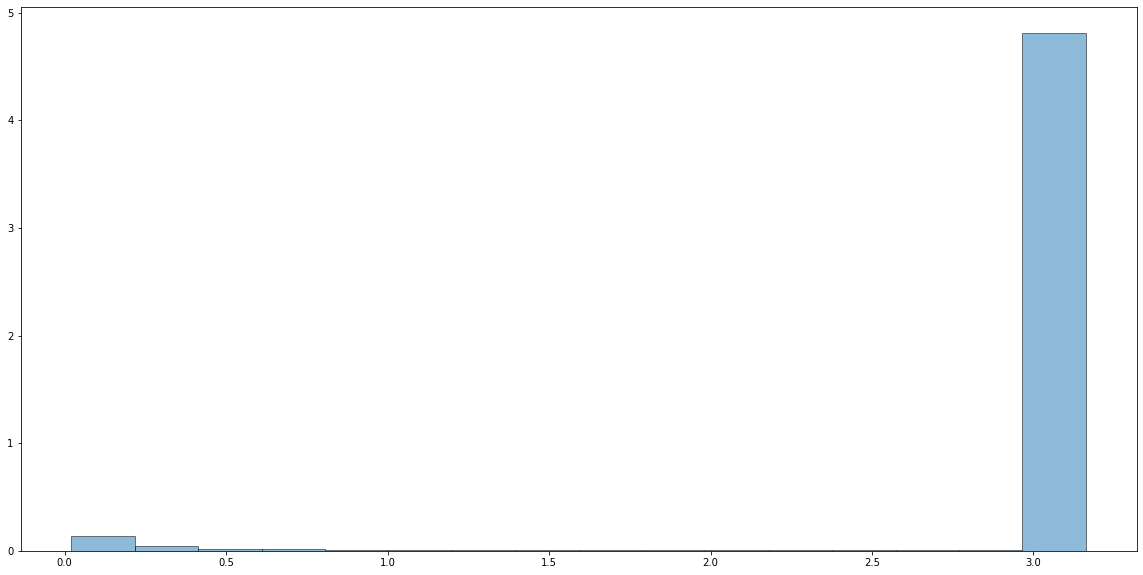

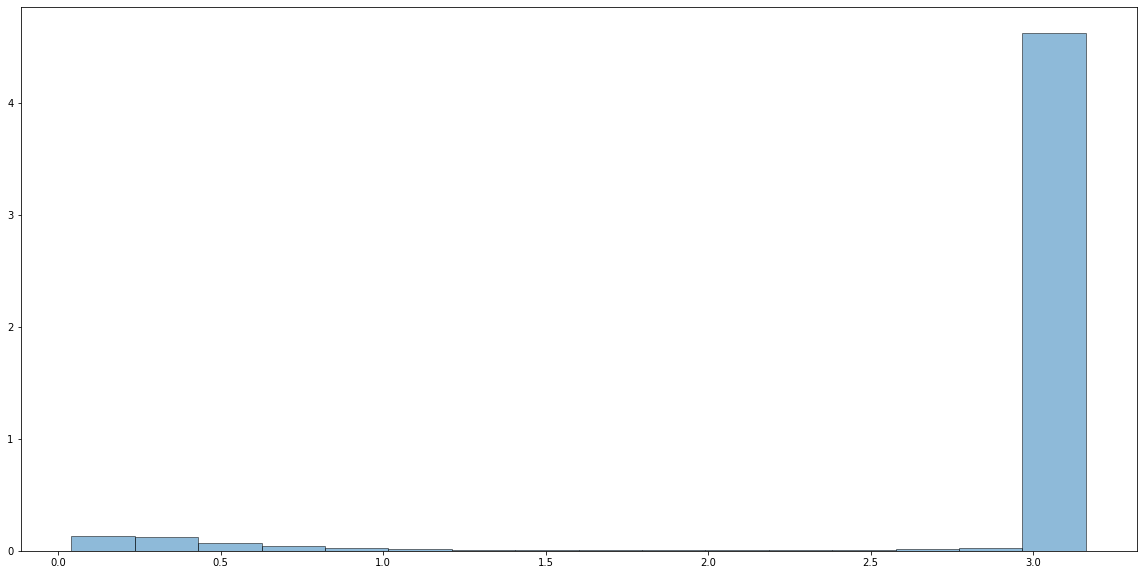

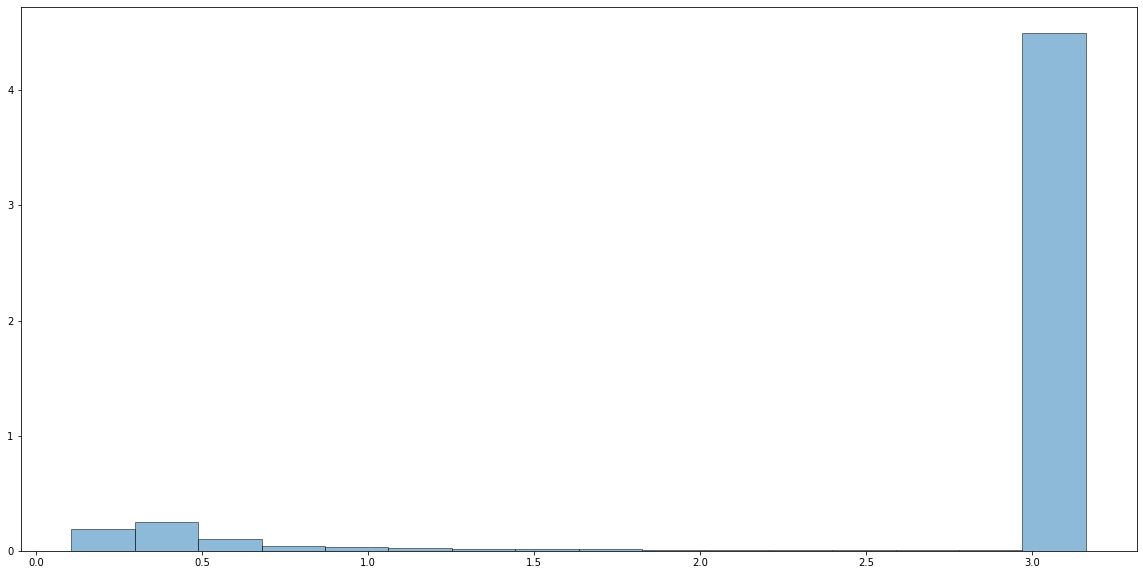

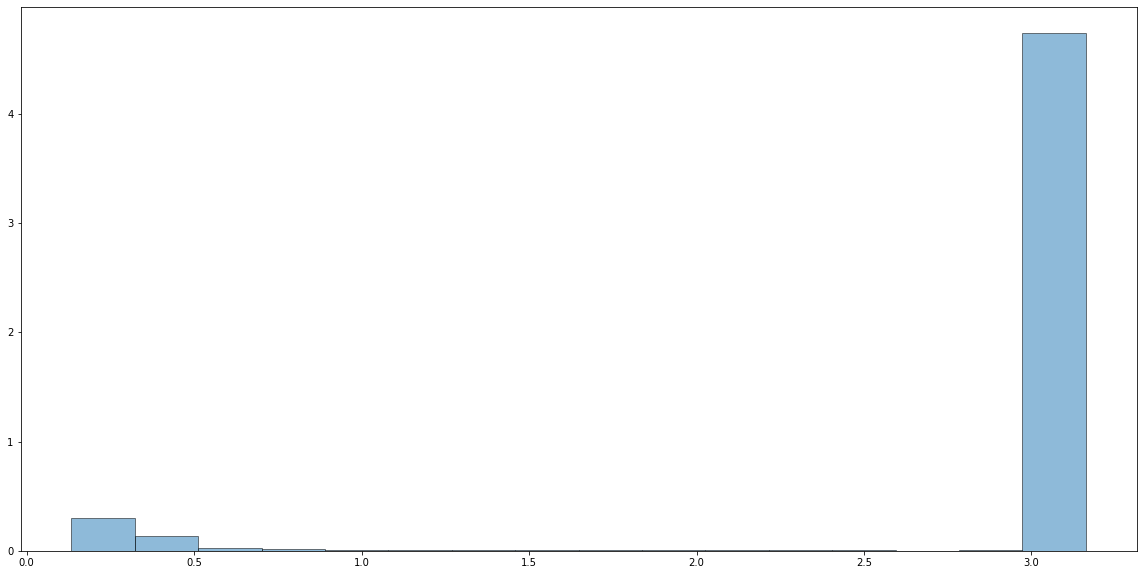

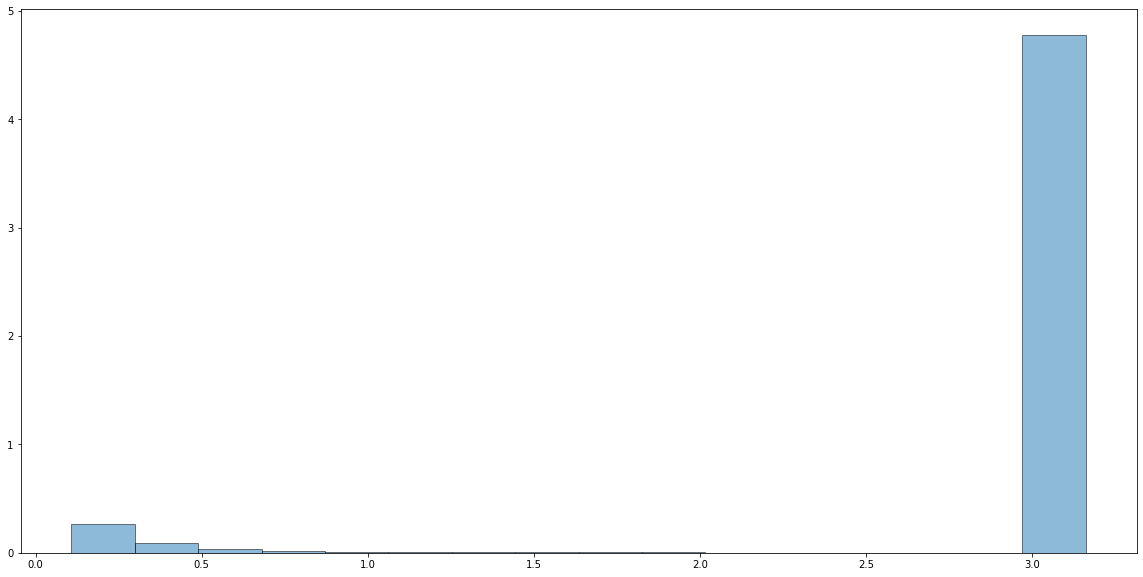

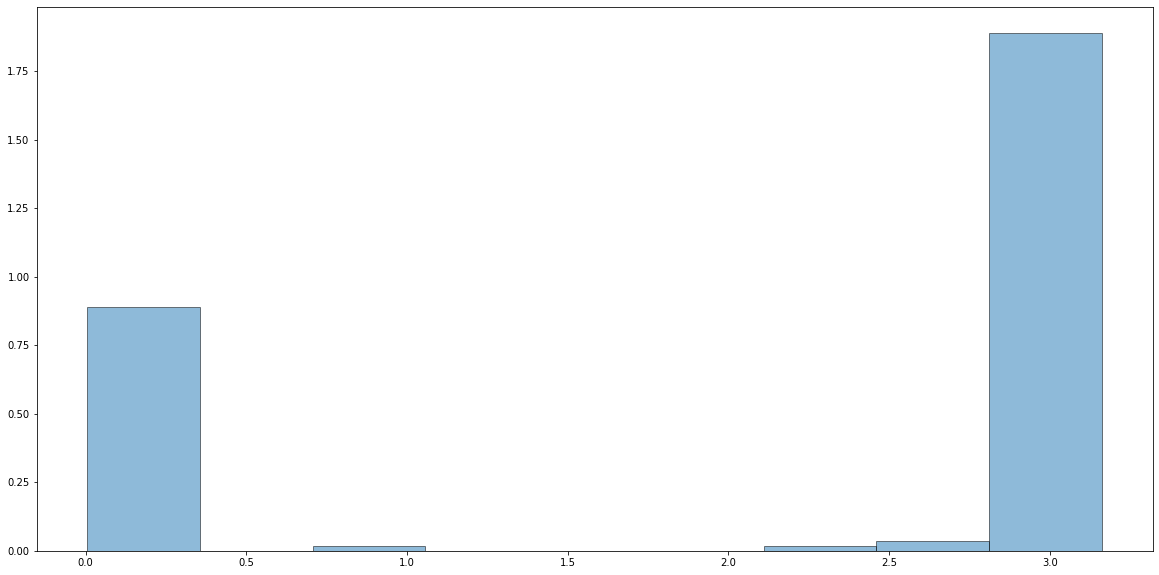

In [87]:
for i, tnsr in enumerate(perceptronDiagH):
    if i%2 == 0:
        plt.hist(torch.flatten(tnsr).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
        plt.show()

0.weight


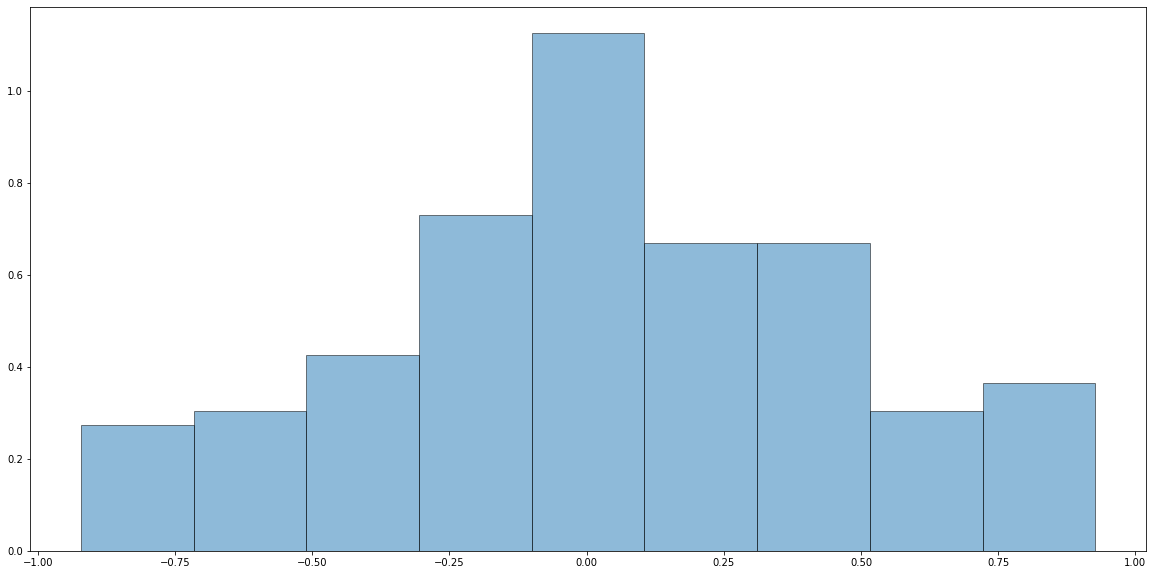

2.weight


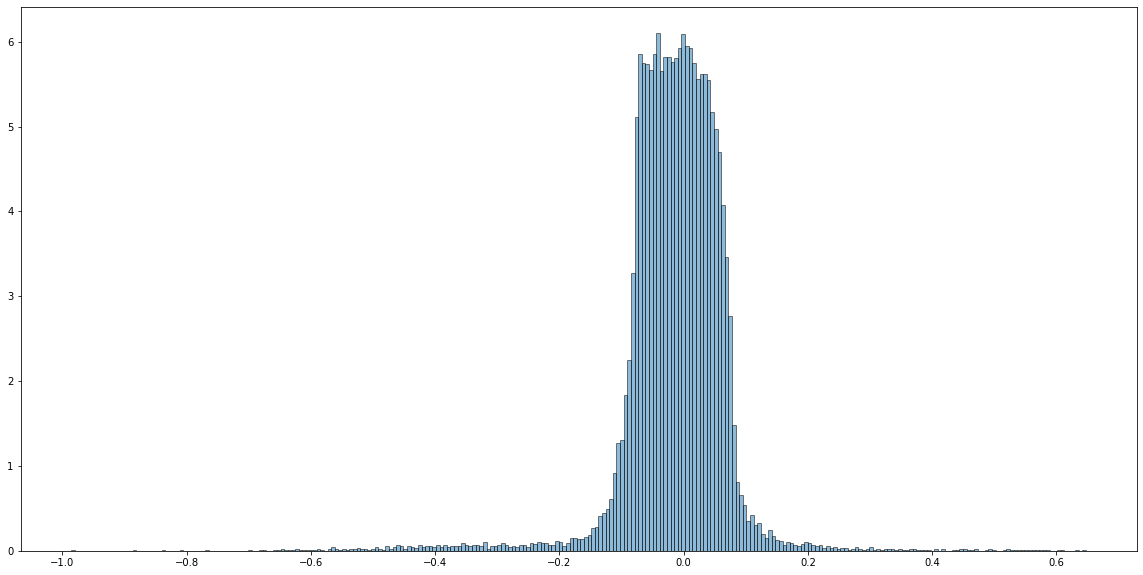

4.weight


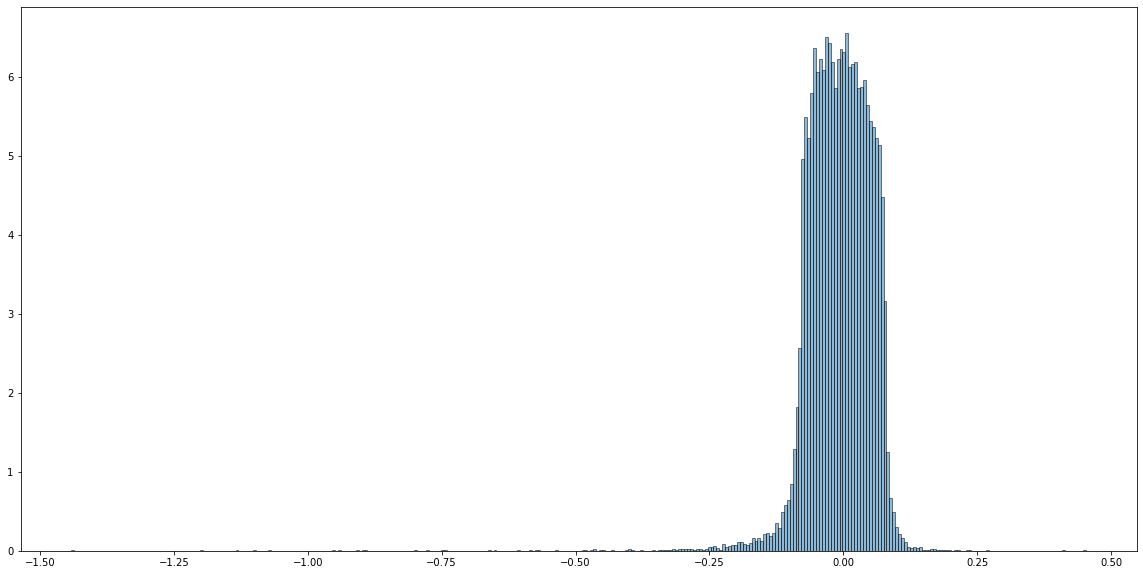

6.weight


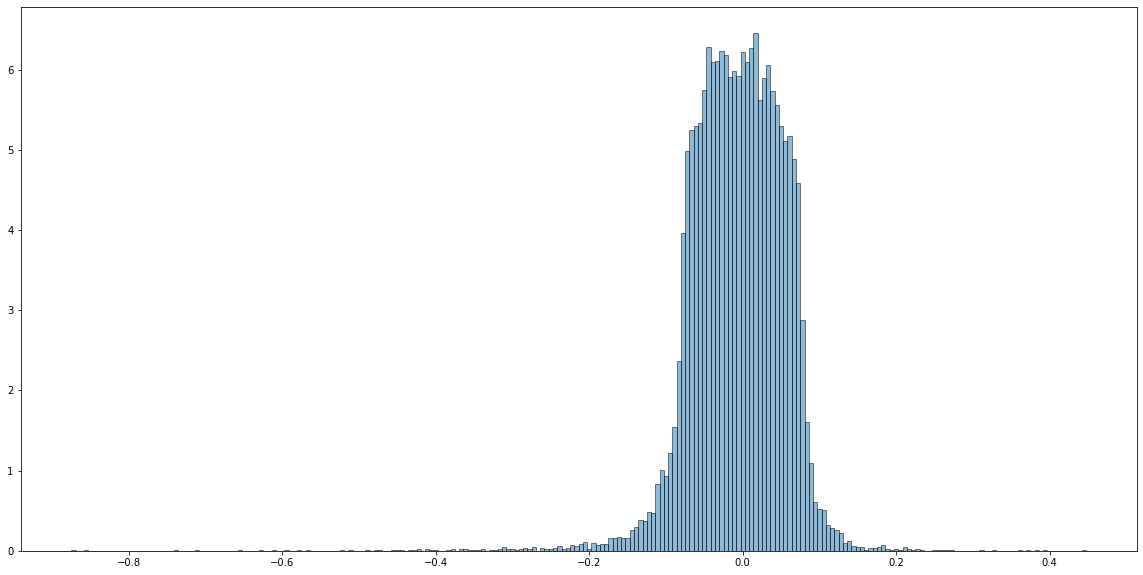

8.weight


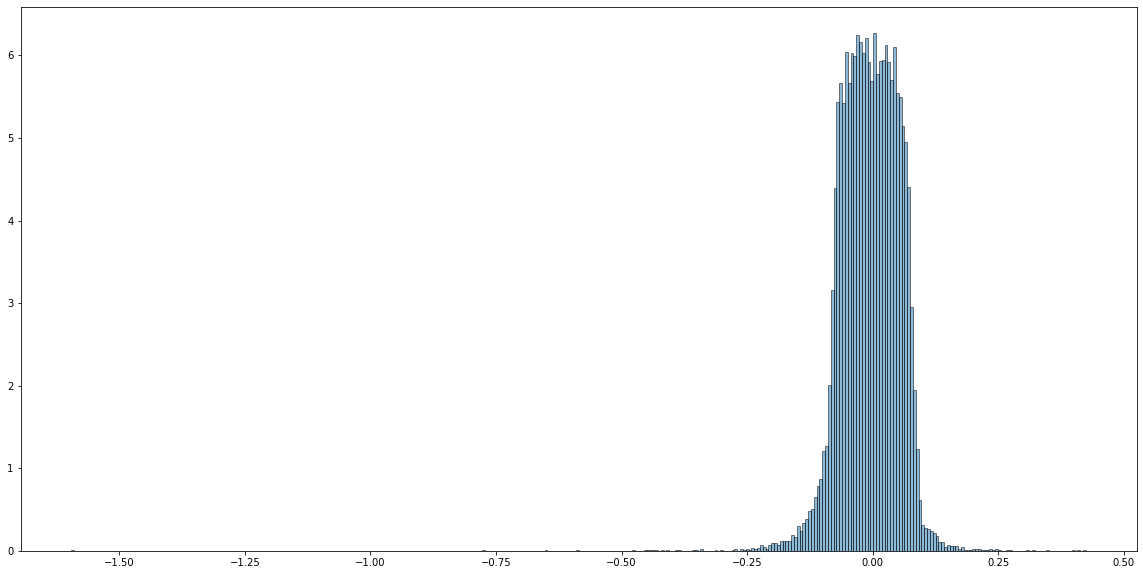

10.weight


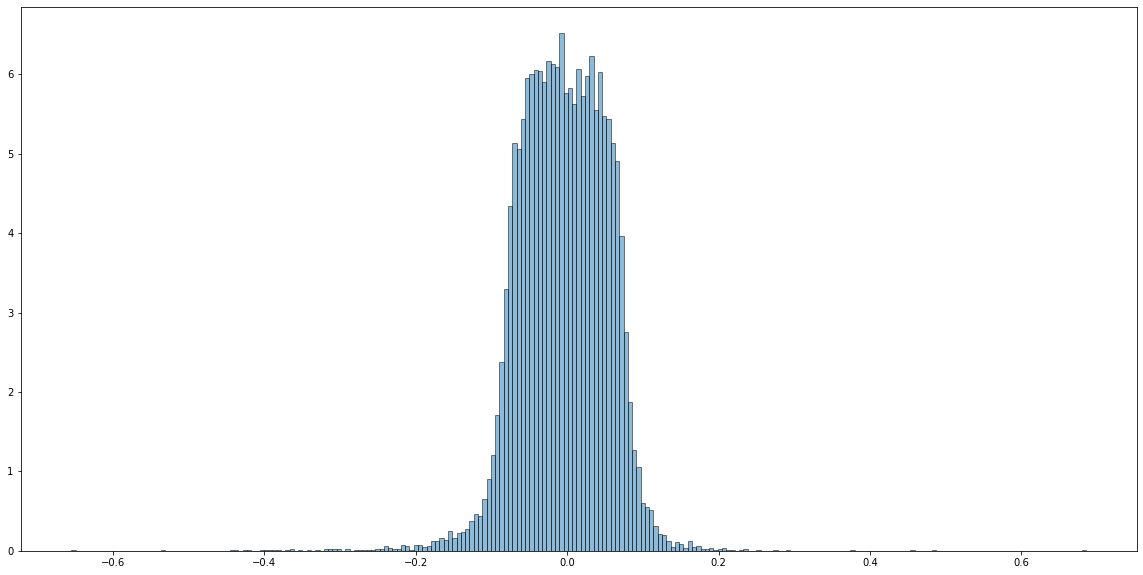

12.weight


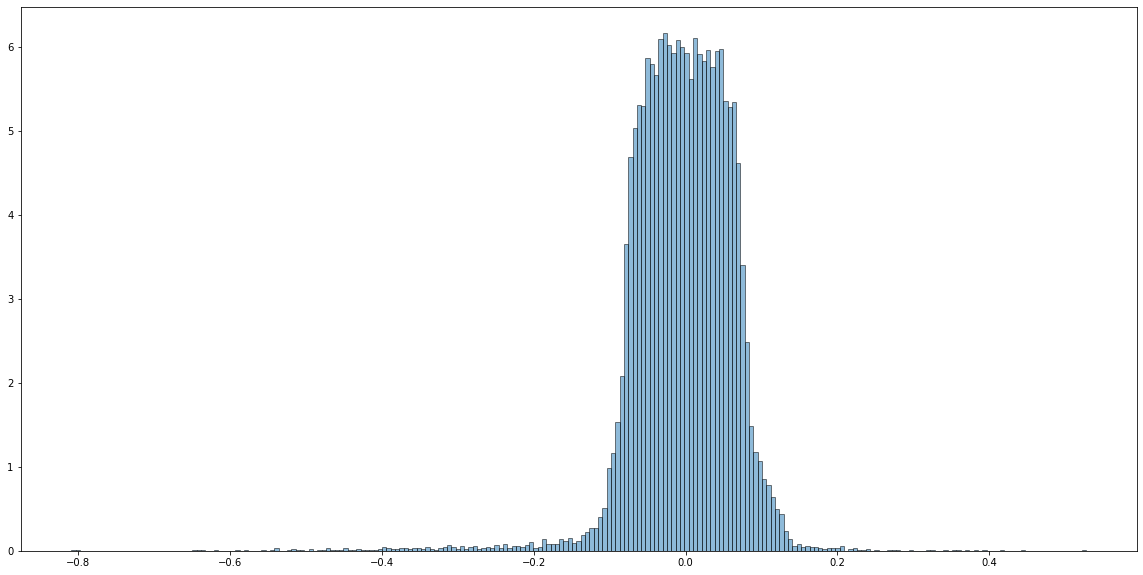

14.weight


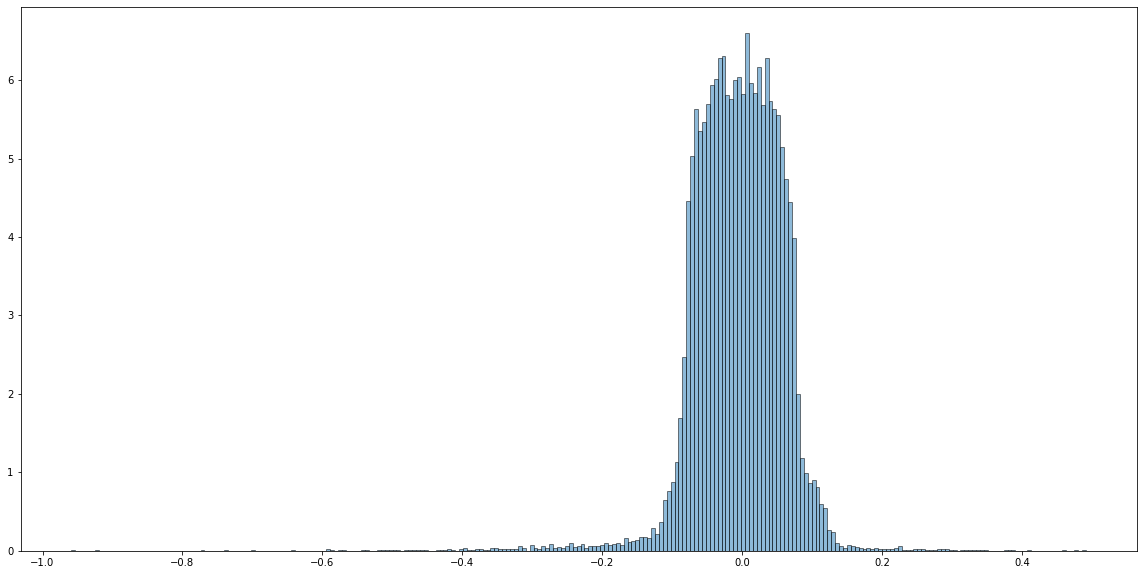

16.weight


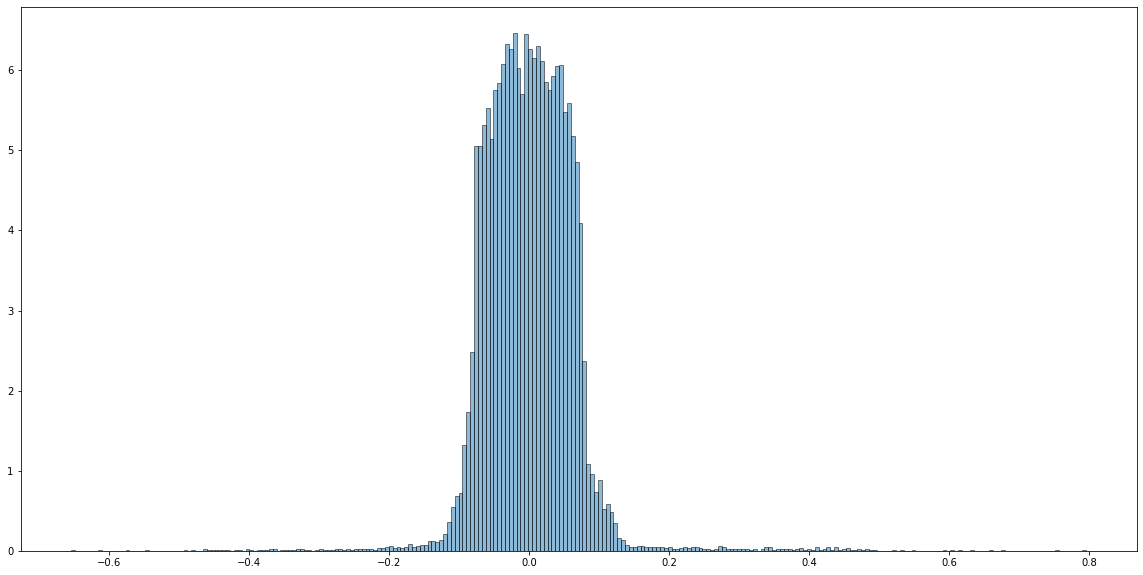

18.weight


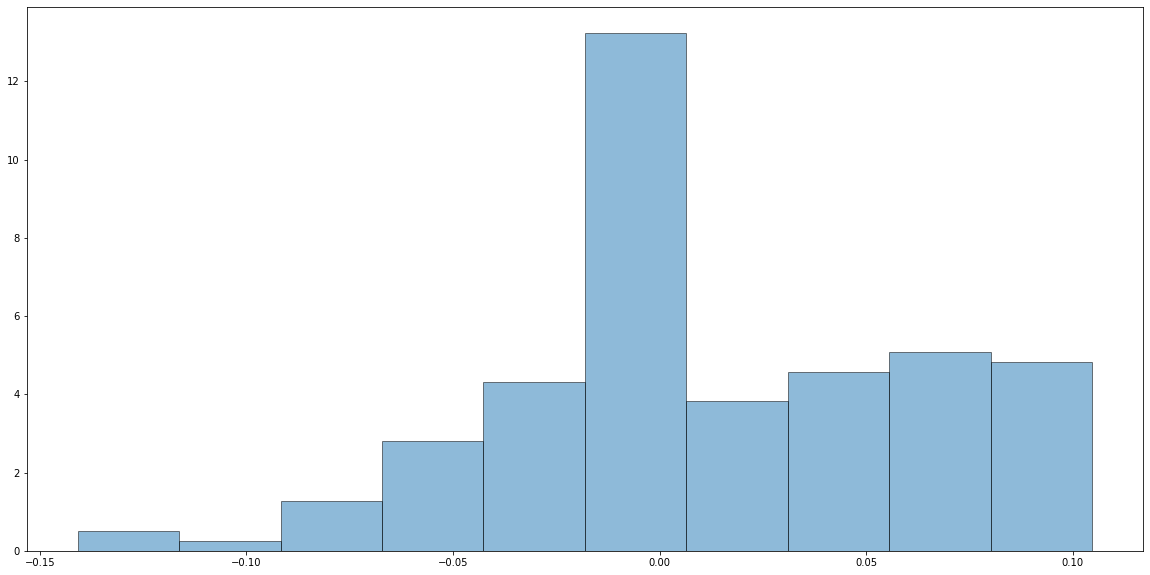

In [86]:
for i, (name, param) in enumerate(net.named_parameters()):
    if i%2 == 0:
        print(name)
        plt.hist(torch.flatten(param).detach().numpy(), bins='auto', edgecolor='black', alpha=.5, density=True)
        plt.show()

layer index: 0
layer name: 0.weight
torch.Size([160, 1]) torch.Size([160, 1])

Pearsons correlation: -0.071


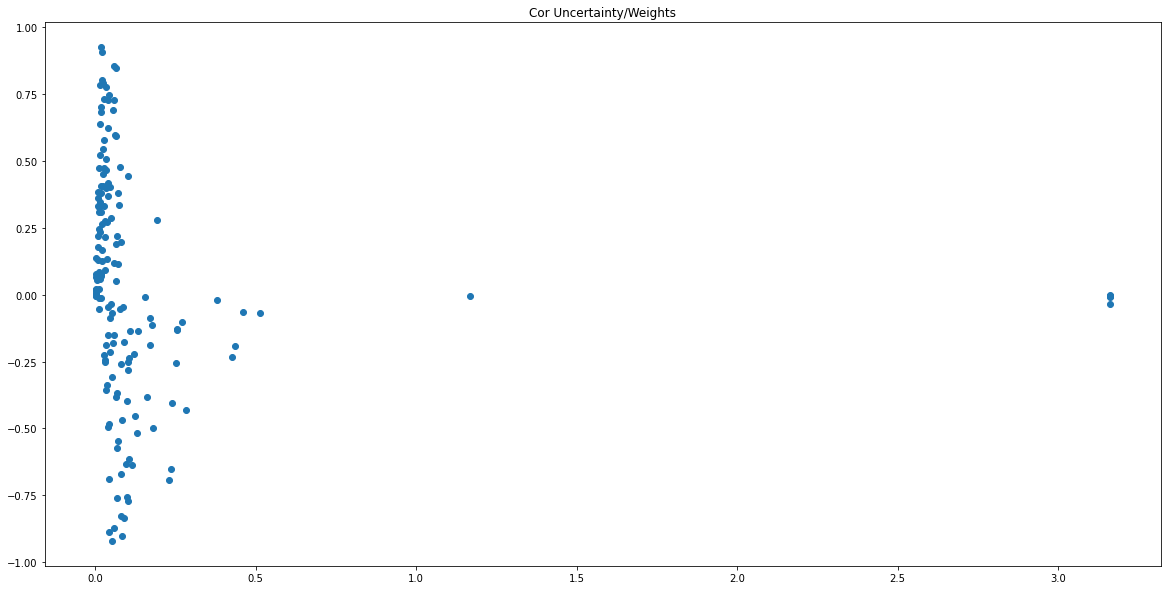

layer index: 2
layer name: 2.weight
torch.Size([160, 160]) torch.Size([160, 160])

Pearsons correlation: -0.076


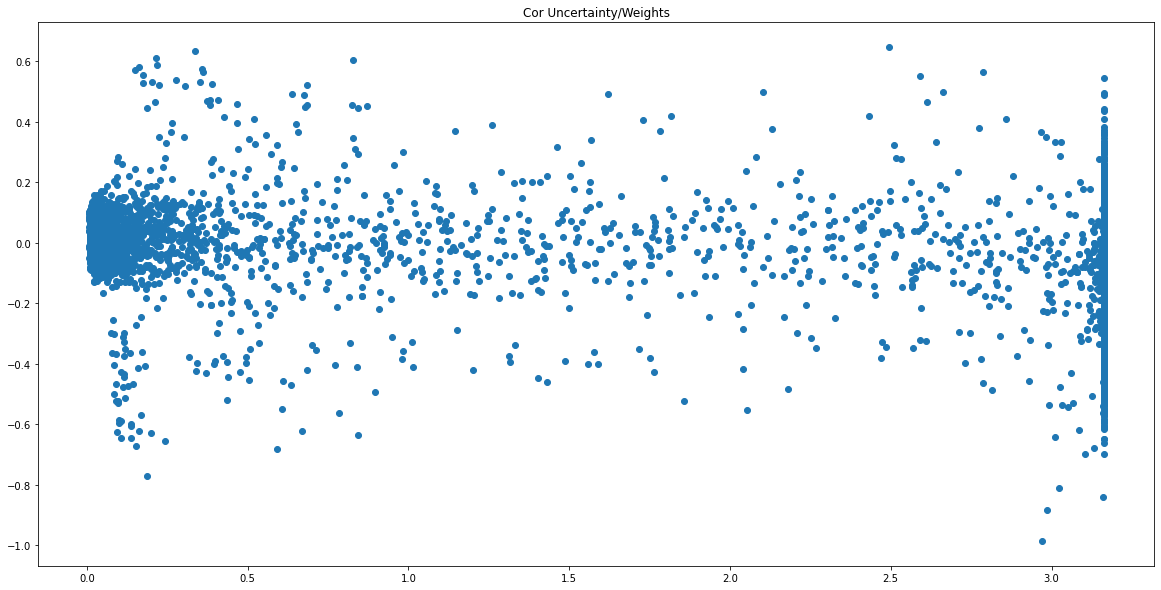

layer index: 4
layer name: 4.weight
torch.Size([160, 160]) torch.Size([160, 160])

Pearsons correlation: -0.026


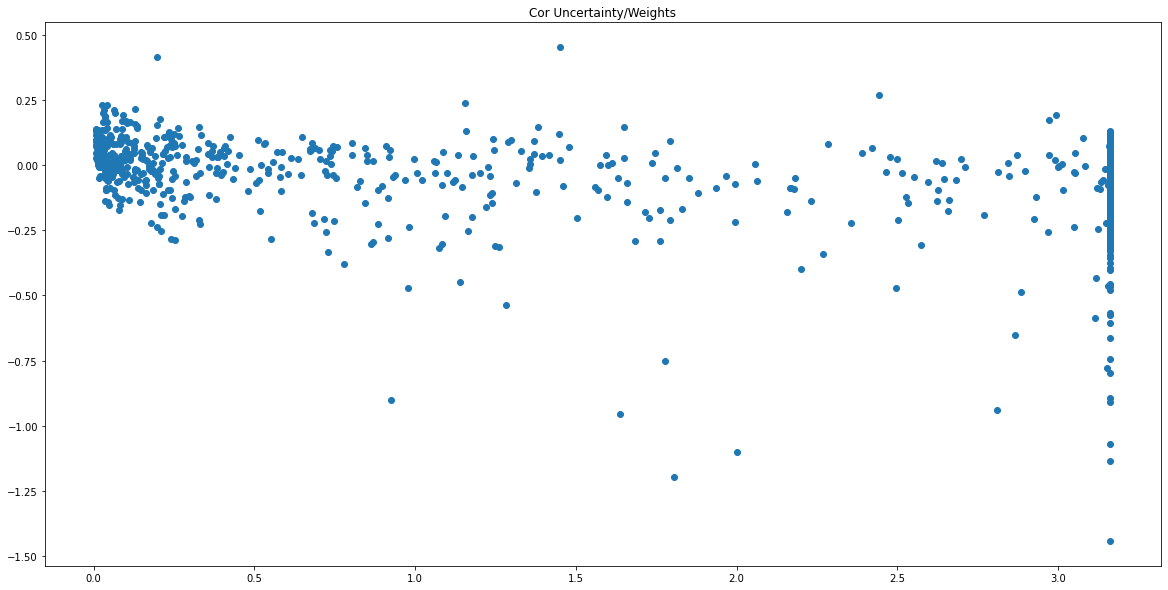

layer index: 6
layer name: 6.weight
torch.Size([160, 160]) torch.Size([160, 160])

Pearsons correlation: -0.077


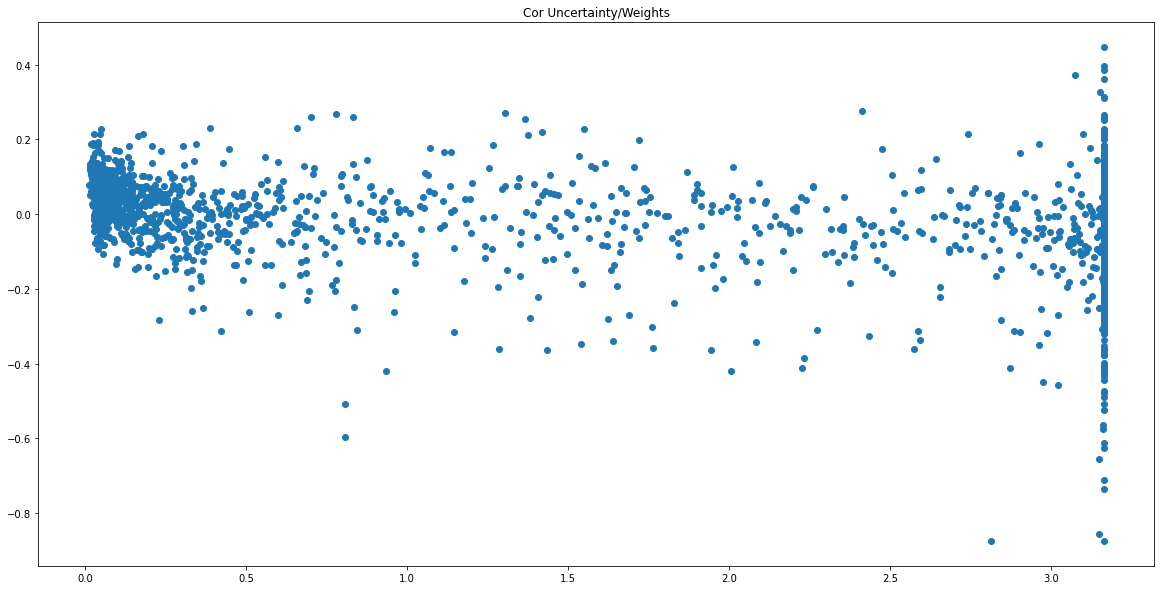

layer index: 8
layer name: 8.weight
torch.Size([160, 160]) torch.Size([160, 160])

Pearsons correlation: -0.155


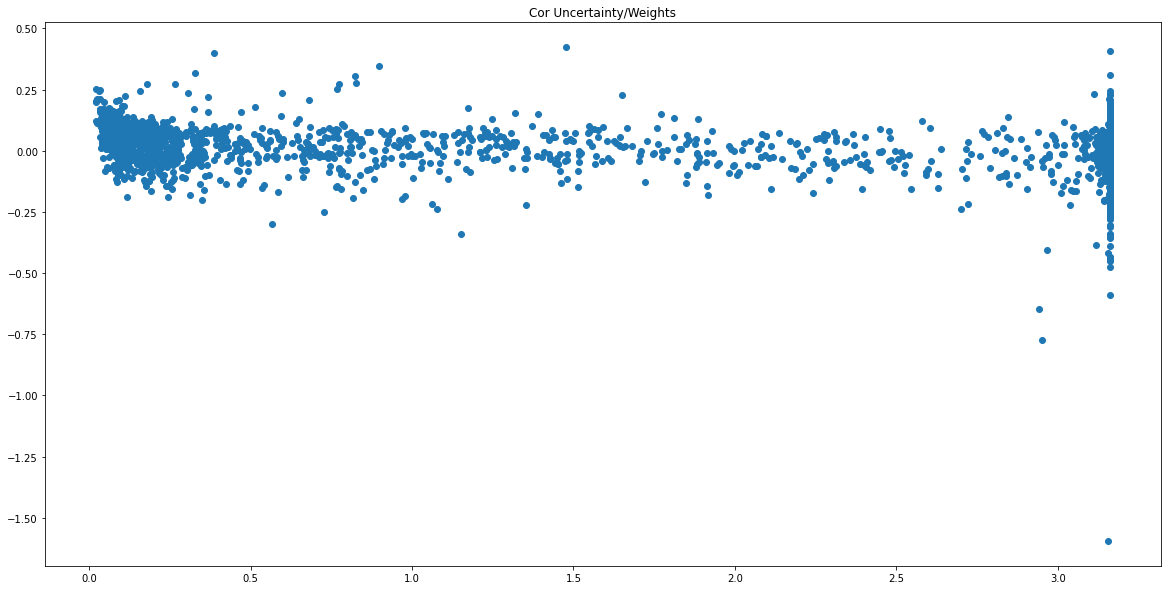

layer index: 10
layer name: 10.weight
torch.Size([160, 160]) torch.Size([160, 160])

Pearsons correlation: -0.241


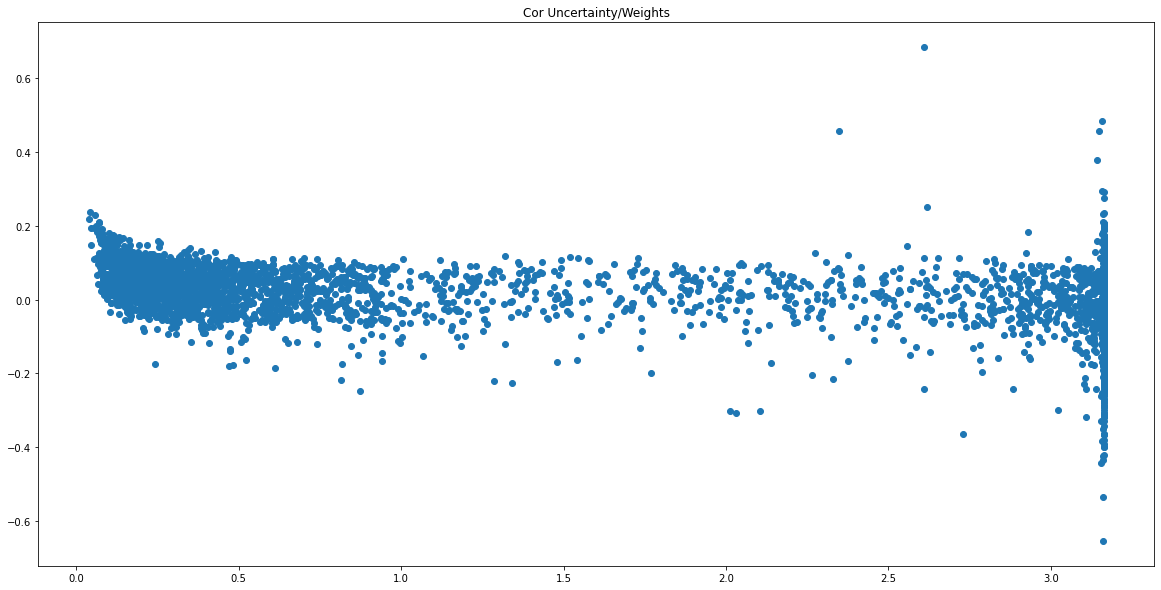

layer index: 12
layer name: 12.weight
torch.Size([160, 160]) torch.Size([160, 160])

Pearsons correlation: -0.286


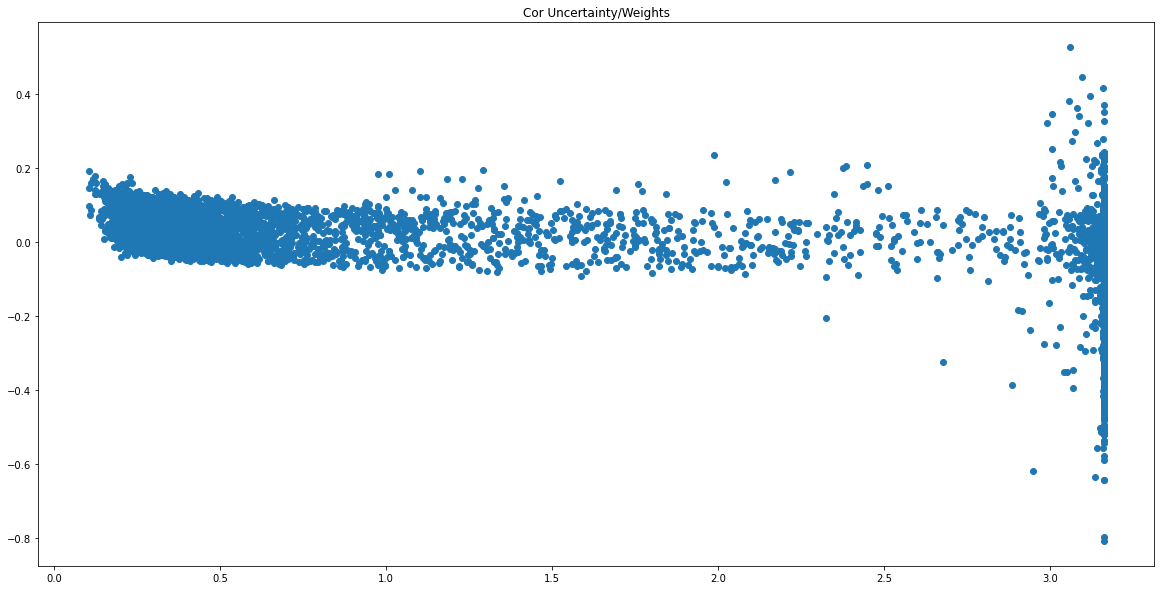

layer index: 14
layer name: 14.weight
torch.Size([160, 160]) torch.Size([160, 160])

Pearsons correlation: -0.262


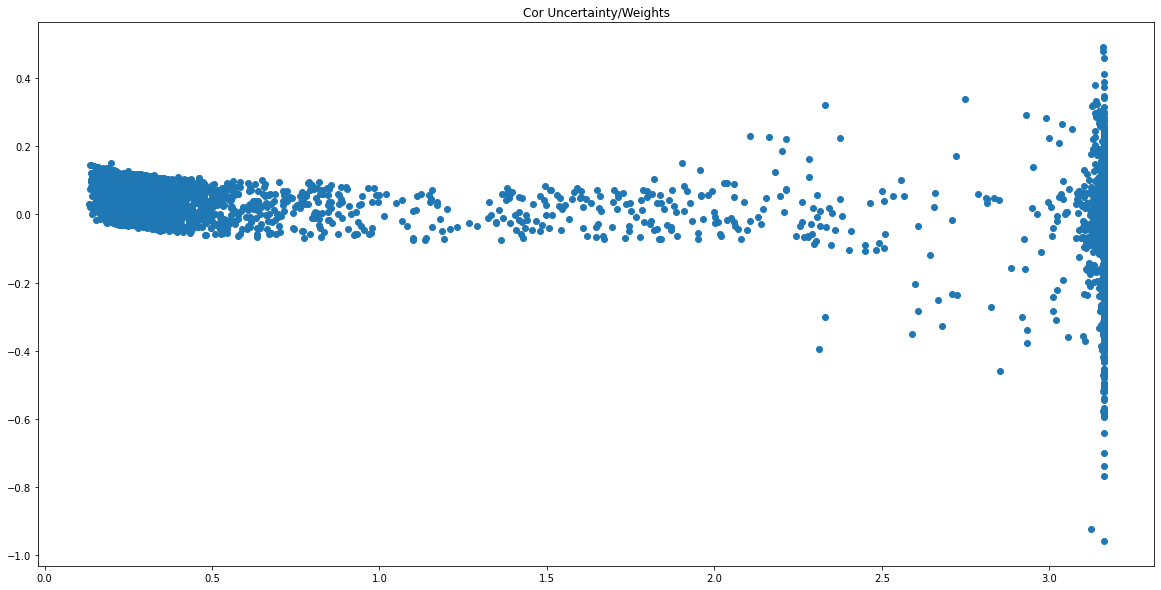

layer index: 16
layer name: 16.weight
torch.Size([160, 160]) torch.Size([160, 160])

Pearsons correlation: -0.214


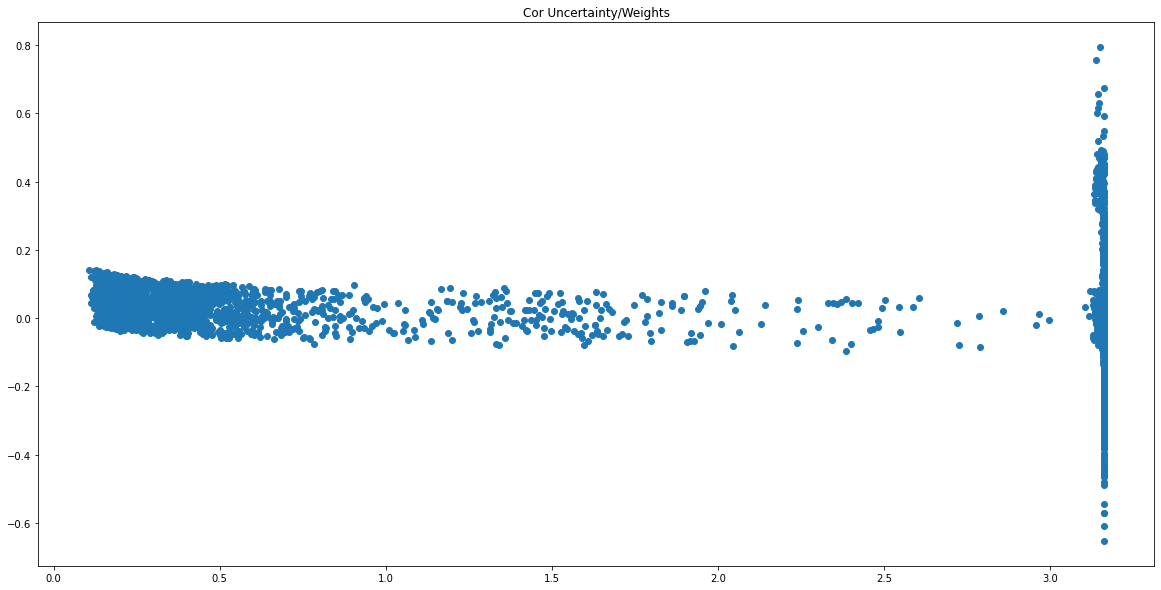

layer index: 18
layer name: 18.weight
torch.Size([1, 160]) torch.Size([1, 160])

Pearsons correlation: -0.713


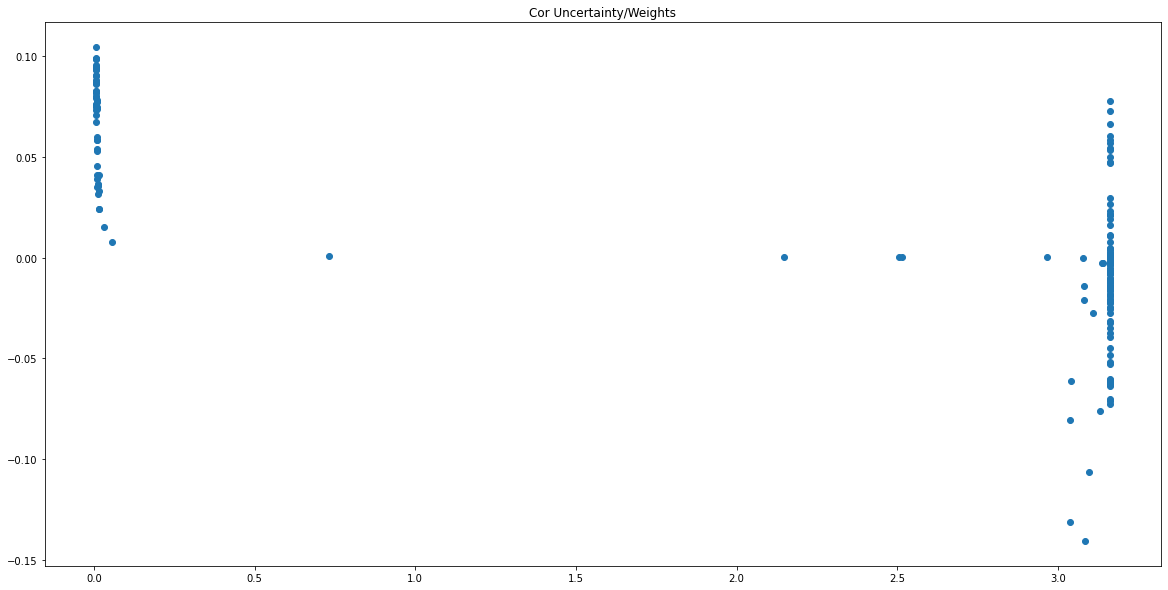

In [84]:
for i, tnsr in enumerate(perceptronDiagH):
    for j, (name, param) in enumerate(net.named_parameters()):
        if i == j and 'weight' in str(name):
            print('layer index: {}'.format(i))
            print('layer name: {}'.format(name))
            print(param.size(), tnsr.size())
            conv2_weights_flattened = torch.flatten(param)
            conv2_uncertainties_flattened = torch.flatten(tnsr)
            plt.scatter(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
            plt.title('Cor Uncertainty/Weights')
            #print(np.cov(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy()))
            corr, _ = pearsonr(conv2_uncertainties_flattened.detach().numpy(), conv2_weights_flattened.detach().numpy())
            print()
            print('Pearsons correlation: %.3f' % corr)
            plt.show()

In [ ]:
for i, data4 in enumerate(data):
    X, y = iter(data4)
    if i > 1:
        break
print(X, y)
#X, y = load_mnist_data()
model = extend(net)
lossfunc = extend(torch.nn.MSELoss())
loss = lossfunc(model(torch.tensor([[X]]).float()), torch.tensor([[y]]).float())

#print(model(torch.tensor([[X]]).float()))
print(loss)

with backpack(DiagHessian()):
    loss.backward()

for name, param in model.named_parameters():
    #print(param.grad)
    print(name)
    #print(param.diag_h)

In [34]:
net1 = NN(sz=1)
net2 = NN(sz=2)
net3 = NN(sz=3)
net4 = NN(sz=4)
net8 = NN(sz=8)
net16 = NN(sz=16)
net32 = NN(sz=32)
net128 = NN(sz=128)

In [41]:
state1 = get_Hessian_NN(net1, train_loader = trainloader, prec0 = 0.001, verbose= False)
state2 = get_Hessian_NN(net2, train_loader = trainloader, prec0 = 0.001, verbose= False)
state3 = get_Hessian_NN(net3, train_loader = trainloader, prec0 = 0.001, verbose= False)
state4 = get_Hessian_NN(net4, train_loader = trainloader, prec0 = 0.001, verbose= False)
state8 = get_Hessian_NN(net8, train_loader = trainloader, prec0 = 0.001, verbose= False)
state16 = get_Hessian_NN(net16, train_loader = trainloader, prec0 = 0.001, verbose= False)
state32 = get_Hessian_NN(net32, train_loader = trainloader, prec0 = 0.001, verbose= False)
state128= get_Hessian_NN(net128, train_loader = trainloader, prec0 = 0.001, verbose= False)

parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([1, 1])
parameter size:  torch.Size([1])
parameter size:  torch.Size([2, 1])
parameter size:  torch.Size([2])
parameter size:  torch.Size([2, 2])
parameter size:  torch.Size([2])
parameter size:  torch.Size([2, 2])
parameter size:  torch.Size([2])
parameter size:  torch.Size([2, 2])
parameter size:  torch.Size([2])
parameter size:  torch.Size([2, 2])
parameter size:  torch.Size([2])
parameter size:  torch.Size([1, 2])
parameter size:  torch.Size([1])


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


parameter size:  torch.Size([3, 1])
parameter size:  torch.Size([3])
parameter size:  torch.Size([3, 3])
parameter size:  torch.Size([3])
parameter size:  torch.Size([3, 3])
parameter size:  torch.Size([3])
parameter size:  torch.Size([3, 3])
parameter size:  torch.Size([3])
parameter size:  torch.Size([3, 3])
parameter size:  torch.Size([3])
parameter size:  torch.Size([1, 3])
parameter size:  torch.Size([1])
parameter size:  torch.Size([4, 1])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([4, 4])
parameter size:  torch.Size([4])
parameter size:  torch.Size([1, 4])
parameter size:  torch.Size([1])
parameter size:  torch.Size([8, 1])
parameter size:  torch.Size([8])
parameter size:  torch.Size([8, 8])
parameter size:  torch.Size([8])
parameter size:  torch.Size([8, 8]

In [42]:
lastlayer = []
for state in [state1, state2, state3, state4, state8, state16, state32, state128]:
    lastl = state[-2]
    lastlayer.append(torch.mean(state[-2]).item())
print(lastlayer)
#print(lastl)

[31.622774124145508, 16.36002540588379, 21.850263595581055, 24.43785285949707, 12.712594032287598, 13.844474792480469, 14.743612289428711, 19.113506317138672]


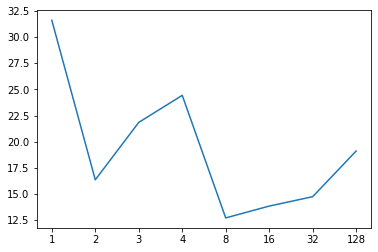

In [43]:
plt.plot(['1', '2', '3', '4', '8', '16', '32', '128'], lastlayer)

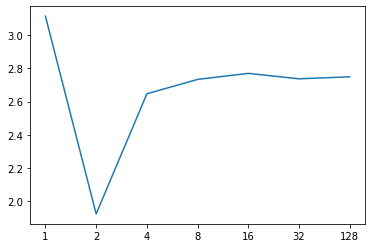

In [32]:
plt.plot(['1', '2', '4', '8', '16', '32', '128'], lastlayer)